# Neural and Generative Information Retrieval Methods
#### Completed for INFS7410 coursework

### Aims


##### Project Aim:  
The aim of the project is to implement a number of information retrieval methods, evaluating and comparing them in the context of real use-cases.

* Implement neural and generative IR methods.
* Compare the methods across different IR paradigms: Traditional, Neural, Generative.
* Reflect on the impact of LLMs on IR, focussing on effectiveness and evaluation.

### The Information Retrieval Task: Web Passage Ranking

In this project, we will consider the (web) passage ranking task in open-domain question answering.

The goal of web passage ranking task is to retrieve and rank passages that best answer user-submitted queries. In a typical web search scenario, users submit queries expecting a ranked list of relevant passages. The core of the task will be to rank these passages effectively to match the intent of each query.

For this task, we will use a **sampled** version of the **MS-MARCO** passage collection. This collection is widely used for training and evaluating passage ranking and retrieval models. The queries used are real search queries submitted to the Microsoft Bing search engine, and the entire collection consists of approximately 8.8 million passages. To learn more about the collection, you can refer to the original [MS-MARCO paper](https://arxiv.org/abs/1611.09268). We are going to work on a sample of MS-MARCO due to time/hardware/computations required to run experiments on the whole collection.

Recently, emerging Large Language Models (LLMs) show potential in empowering search engines, especially in generating answers to users’ queries. This approach, known as Retrieval-Augmented Generation (RAG), combines Information Retrieval (IR) with generative language models to provide a better user experience. In addition to the passage ranking task, we will also explore the application of RAG and evaluate its performance.

### Files for This Project
- `collection.zip`
  - **Download** and **unzip** the file into your working directory.
- `main.ipynb` (This notebook)


The following collection is used for the project:
- **MS-MARCO**:
  - `./sampled_collection.jsonl`
  - `./sampled_queries.tsv`
  - `./sampled_qrels.txt`

Specifically:

* `sampled_collection.jsonl`: (**5,853** passages) Containing the texts to be retrieved for each query.
* `sampled_queries.tsv`: (**10** queries) Sampled queries used for retrieval, each line containing a topic id and the query text.
* `sampled_qrels.txt`: Containing relevance judgements for runs in TREC format <qid, Q0, doc_id, rank, score, tag>.

### Review of the IR Workflow
To conduct a complete experiment for the IR tasks in this project, the following three key stages are followed: `Indexing -> Retrieval -> Evaluation`. Each stage involves a corresponding portion of data from the collection. A collection typically comprises a corpus, queries, and a qrel. These are illustrated below:
<center>
<img src="images/ir-workflow.svg" alt="ir-workflow" width="500" title="Fig.1 IR Workflow"/>
</center>

### What this project contains:

* **Implementations** and **evaluations** of methods used.
* **Write-up** about the **retrieval methods** used, including:
  - **description** of the method you implemented.
  - **evaluation settings** with explanation followed.
  - **discussion** of the findings.

In this project, the following implementations and evaluations are performed:
<center>
<img src="images/project2-task.svg" alt="project2-task" width="500" title="Fig.2 IR Project-2-Illustration"/>
</center>

### Methods to Implement

* Indexing
  - **Pyserini index command**: Collection used in this project is first indexed.
* IR models
  - **Pyserini BM25**: (traditional) Using the Pyserini API to ***retrieve*** top-k documents.
  - **Standard DPR Dense Retriever** (neural): Using standard DPR to ***retrieve*** top-k documents.
  - **TILDEv2** (neural): Using TILDEv2 to ***retrieve*** top-k documents.
  - **TinyLlama** (generative): Using TinyLlama to implement RAG.


**Task-1**: *Traditional model vs. Neural models*
1. Run **BM25** with the default k,b settings on the given dataset (k=1.3, b=0.75) to retrieve the top-10 passages as the **baseline**.
2. Run **DPR** and **TILDEv2** on the given dataset to **retrieve** top-10 passages. Compare the results from each method to the BM25 baseline separately.
3. Conduct **statistical significance tests** on the models’ retrieval effectiveness.
4. Summarise the results in a table, including the statistical significance.
5. Create a **gain-loss plot** comparing each neural model against the BM25 baseline at the query level.


**Task-2**: *Exploring Generative models*
1. Use TinyLlama to do RAG on each query by taking the top-3 retrieved documents from both traditional & neural methods, and generating answers for the query separately.
2. Design **two** methods/measures to evaluate the RAG-generated answers for each query.
3. Document the methods and measures used, as well as analysis of the results for each query. Explain the measure scores assigned to the generated answers and justify your reasoning for each score.
4. Create a **correlation plot** for each RAG evaluation measure. Each plot should display the correlation between the differences in retrieval performance (NDCG@3) and the differences in the RAG evaluation measure, comparing the results derived from the best Task-1 model (either DPR or TILDEv2) with the results derived from BM25.

***Bonus Tasks***
- Implement **point-wise** and **pair-wise** reranking with an LLM on top-10 results from the best model identified in task-1 based on NDCG@3. These results should also be included into the Task-1 evalaution requirements (e.g. table, stat test, gain-loss plot).
- Design **two additional** methods to evaluate RAG generated answers. These measures must be different from those already devised in Task-2 and should address a different aspect of the information need. Provide a detailed explanation of the methods/measures you choose. Follow the Task-2 evaluation requirements (including result analysis for each query, correlation plots).


### Discussions
**Task-1**: *Traditional model vs. Neural models*
1. Comment on **trends and differences** observed in your results. Is there a method that **consistently outperforms** others on all the queries for the dataset?

**Task-2**: *Exploring Generative models*
1. Perform **correlation** plotting and answer the question: How does retrieval effectiveness impact the quality of the generated responses, and why?

### Evaluation Measures
Evaluate the retrieval methods using the following measures:

**Task-1**: *Traditional model vs. Neural models*
- **NDCG at 3** (`ndcg_cut_3`): Use this as the measure for comparing and reporting results from traditional and neural methods.

**Task-2**: *Exploring Generative models*
- **customised**: Use this as the measure for evaluating LLM generated results.

All **gain-loss plots** should be produced with respect to **nDCG at 3**.

For **statistical significance analysis**, use the **paired t-test** and distinguish between **p < 0.05** and **p < 0.01**.


---

## Task-1: *Traditional model vs. Neural models*

### Implementation
In task 1, we begin by implementing the following retrieval models: **BM25**, **DPR**, and **TILDEv2**.

In [1]:
import torch
import numpy as np
import pandas as pd
import pytrec_eval
import math
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from transformers import BertModel, BertTokenizer, AutoTokenizer, BertConfig, PreTrainedModel, AutoModelForCausalLM
import torch.nn.functional as F
import re
import json
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

#### Indexing Collection

Here, we build an index on the sampled MS-MARCO collection to improve computation performance, which will be used by the BM25 retrieval method.

In [1]:
!python -m pyserini.index.lucene \
  -collection JsonCollection \
  -generator DefaultLuceneDocumentGenerator \
  -input infs7410_project_part_2_collection \
  -index indexes/lucene-index-msmarco-Porter-NoStopwords \
  -threads 9 \
  -storeDocvectors -storeRaw \
  -stemmer porter

2024-09-27 20:34:05,937 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2024-09-27 20:34:05,938 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2024-09-27 20:34:05,938 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2024-09-27 20:34:05,938 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: infs7410_project_part_2_collection
2024-09-27 20:34:05,938 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2024-09-27 20:34:05,939 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2024-09-27 20:34:05,939 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2024-09-27 20:34:05,939 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en
2024-09-27 20:34:05,939 INFO  [main] index.Inde

#### Caching and General Functions
This section implements general indexing of the corpus, as well as functions that are used for evaluating the nDCG@3 metric and writing retrieved results to a run file.

In [2]:
stemming = 'porter'
stopwords = False
index = 'indexes/lucene-index-msmarco-Porter-NoStopwords'

In [3]:
from pyserini.search import SimpleSearcher
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pyserini.index import IndexReader
from tqdm import tqdm

lucene_analyzer = get_lucene_analyzer(stemming=stemming, stopwords=stopwords)
analyzer = Analyzer(lucene_analyzer)
searcher = SimpleSearcher(index)
searcher.set_analyzer(lucene_analyzer)
index_reader = IndexReader(index)

# Get the total number of documents in the collection
total_doc_num = index_reader.stats()['documents']
# Get all document IDs of the collection
doc_ids = [index_reader.convert_internal_docid_to_collection_docid(i) for i in tqdm(range(total_doc_num))]

# Cache document vectors: dict{'doc_id': {'term_1': term_freq, ...}}
doc_vec_dict = {}
for docid in tqdm(doc_ids, desc="Caching doc vec:"):
        doc_vec_dict[docid] = index_reader.get_document_vector(docid)

# Cache document lengths for each document
doc_len_dict = {}
for docid in tqdm(doc_ids, desc="Caching doc len:"):
    doc_len_dict[docid] = sum(doc_vec_dict[docid].values())

# Average document length
avg_dl = index_reader.stats()["total_terms"] / index_reader.stats()["documents"]

SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead


Caching doc len:: 100%|██████████| 5853/5853 [00:00<00:00, 1245586.35it/s]


In [4]:
def search(query: str, k: int=1000, scorer=None):
    """
    Inputs: 
        query (str): the query string to perform the search.
        k (int): the number of documents to be returned.
        scorer: your implemented scoring function, such as bm25.
    
    Output:
        results (list): the sorted result list, a list of tuples.
                        The first element in the tuples is the docid, 
                        the second is the doc score.
    """
    assert scorer is not None

    # Get the analyzed term list
    q_terms = analyzer.analyze(query)
    doc_scores = {}
    for term in q_terms:
        # Get the posting list for the current term
        postings_list = index_reader.get_postings_list(term, analyzer=None)
        df = index_reader.get_term_counts(term, analyzer=None)[0] # Get document frequency of the current term
        if postings_list is not None:
            # Tterate the posting list
            for posting in postings_list:
                internal_id = posting.docid
                docid = index_reader.convert_internal_docid_to_collection_docid(internal_id) # Convert pyserini internal docid to the actual docid
                tf = posting.tf
                doc_len = doc_len_dict[docid]

                # Call the scoring function (you will implement these below).
                score = scorer(tf, df, doc_len)
                if docid in doc_scores.keys():
                    doc_scores[docid] += score
                else:
                    doc_scores[docid] = score

    # Sort the results by the score.
    results = [(docid, doc_socre) for docid, doc_socre in doc_scores.items()]
    results = sorted(results, key=lambda x: x[1], reverse=True)[:k]
    return results


def write_results(file_name, all_results):
    """
    Writes the results of a run into a file.

    Parameters:
        file_name: Name of file to write to.
        all_results: Dictionary of {topic_id: results list}.
    """
    with open(file_name, "w") as f:
        for result in all_results.items():
            for i, j in enumerate(result[1]):
                f.write(f"{result[0]} Q0 {j[0]} {i} {j[1]} J\n")


def run_queries(query_file, run_file, k: int=10, scorer=None):
    """
    Reads query file and performs search for each topic.
    
    Parameters:
        query_file: TSV file with queries to run.
        run_file: File to write run results to.
        k: Number of documents to return, default=1000.
        scorer: Scoring function.
    """
    # Read query file for queries to perform and corresponding topic IDs
    queries = []
    with open(query_file, "r") as f:
        for line in f.readlines():
            parts = line.split("\t") # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    all_results = {}

    for topic_id, query in queries:
        search_results = search(query=query, k=k, scorer=scorer)
        all_results[topic_id] = search_results
    
    write_results(run_file, all_results)


def evaluate_ndcg3(run_file, qrel_file):
    """
    Evaluates the run results using the specified measure.

    Parameters:
        run_file: File run results are written to.
        qrel_file: File where qrel results are stored.
        measure: Measure for evaluation.
    """
    # Open the qrels file.
    with open(qrel_file, "r") as f:
        qrel_results = pytrec_eval.parse_qrel(f)

    # Open the run fle we created above.
    with open(run_file, "r") as f:
        run_results = pytrec_eval.parse_run(f)

    evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=qrel_results, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)

    ndcg3 = pytrec_eval.compute_aggregated_measure("ndcg_cut_3",
                            [query_measures["ndcg_cut_3"]for query_measures in results.values()])
    
    return ndcg3

In [5]:
# Setting device to use GPU if available (or MPS if using Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [ ]:
# Constants for file names
QUERIES = "collection/sampled_queries.tsv"
QRELS = "collection/sampled_qrels.txt"
CORPUS = "collection/sampled_collection.jsonl"

------

#### BM25

BM25 is a ranking function that can be used to assess the relevance of documents to a given search query. BM25 calculates a score for each document based on the query terms it contains, considering both term frequency (TF) and inverse document frequency (IDF). In contrast to TF-IDF, however, it introduces a saturation function for term frequency which controls the contribution of term occurrences, as well as a document length normalization to handle variations in document sizes. The formula for BM25 is:

$$
\text{score}(D,Q)=\sum^{|Q|}_{i=1}\text{idf}(q_i)\cdot\frac{f(q_i,D)\cdot(k_1+1)}{f(q_i,D)+k_1\cdot(1-b+b\cdot\frac{|D|}{avgdl})}
$$

In this formula, $k_1$ and $b$ are parameters, with $k_1$ being the parameter which controls saturation (larger $k_1$ means term frequencies contribute more, $k_1>0$), and $b$ is the parameter which controls document length normalisation ($0<=b<=1$, where 1 means full normalisation and 0 is no normalisation).

In [7]:
def bm25(tf, df, doc_len):    
    # Calculate the IDF component with smoothing
    idf = math.log((total_doc_num - df + 0.5) / (df + 0.5) + 1)
    
    # Calculate the TF component with document length normalization
    tf_component = ((k_1 + 1) * tf) / (k_1 * ((1 - b) + b * (doc_len / avg_dl)) + tf)
    
    # Return the BM25 score
    return idf * tf_component

##### Baseline BM25 Run

To create a baseline for comparing results to, we will retrieve documents using BM25 with k=1.3, b=0.75.

In [8]:
k_1 = 1.3
b = 0.75

baseline_bm25_file = "runs/bm25-k=1.3-b=0.75.run"

run_queries(QUERIES, baseline_bm25_file, scorer=bm25, k=10)
baseline_bm25_ndcg3 = evaluate_ndcg3(baseline_bm25_file, QRELS)
print("nDCG at 3 for Baseline BM25 (k=1.3, b=0.75) on Sampled MS-MARCO: ", baseline_bm25_ndcg3)

nDCG at 3 for Baseline BM25 (k=1.3, b=0.75) on Sampled MS-MARCO:  0.5332269283060149


------

#### DPR: Dense Passage Retrieval

Dense Passage Retrieval (DPR) is a retrieval method that leverages dense embeddings for both queries and documents. The key component of DPR is the LLM-based encoder, which is a neural networks trained to map queries and documents into a vector space. Once encoded, DPR measures the similarity between query and document embeddings using an inner product, which determines the relevance of documents to a given query.

The steps for performing DPR are:
1. Document Encoding: An encoder encodes every document into a dense vector representing the document's content.
2. Query Encoding: An encoder takes the text of the query and generates an embedding to represent the query in the dense vector space.
3. Similarity Search: After encoding all documents and queries, DPR computes the inner product between the query vector and document vectors. The higher the dot product, the more relevant the document is to the query. The inner product between the query embedding $q$ and document embedding $d$ is formulated as:

    $$
    \text{similarity}(q, d) = q \cdot d = \sum_{i=1}^{n} q_i \cdot d_i
    $$

    Where:
    - $q_i$ and $d_i$ are the $i$-th components of the query and document embeddings, respectively.
    - $n$ is the dimensionality of the embedding space.

    This gives a result that is a scalar value which measures how aligned the query and document are, with higher values indicating higher relevance.

4. Retrieval: All documents in the corpus are ranked based on their similarity scores with the query, and the top-ranked documents are returned as the most relevant to the query.

In [9]:
def dpr_encode_documents(corpus_path, tokenizer, encoder):
    corpus = pd.read_json(path_or_buf=corpus_path, lines=True) # Read in corpus as a DataFrame
    embeddings = [] # List of embeddings in order of documents present in corpus

    for doc_index in range(len(corpus)):
        document = corpus.loc[doc_index] # Gives doc id and content
        doc_tokens = tokenizer([document["contents"]], return_tensors="pt", padding="longest", truncation=True).to(device)
        doc_embedding = encoder(**doc_tokens)[0][:, 0, :].detach().cpu().numpy().flatten()
        embeddings.append((document["id"], doc_embedding)) # Track embeddings

    return embeddings


def dpr_retrieval(tokenizer, encoder, embeddings, k):
    # Read query file for queries to perform and corresponding topic IDs
    queries = []
    with open(QUERIES, "r") as f:
        for line in f.readlines():
            parts = line.split("\t") # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    all_results = {}

    for query_id, query in queries:
        # Get embedding for query
        query_tokens = tokenizer([query], return_tensors="pt", padding="longest", truncation=True).to(device)
        query_embedding = encoder(**query_tokens)[0][:, 0, :].detach().cpu().numpy().flatten()

        scores = []
        # Find similarity between query embedding and all available documents to search against
        for doc_id, doc_embedding in embeddings:
            scores.append((doc_id, np.dot(query_embedding, doc_embedding))) # Track scores using tuple of (doc_id, score)

        # Find top scoring documents
        scores.sort(key=lambda x: x[1], reverse=True) # Sort by score (index 1 of tuple)
        all_results[query_id] = scores[:k]

    write_results("runs/dpr_retrieval.run", all_results)

In [10]:
# Initialize the tokenizer and model
dpr_encoder = BertModel.from_pretrained("ielabgroup/StandardBERT-DR").eval()
dpr_tokenizer = BertTokenizer.from_pretrained("ielabgroup/StandardBERT-DR")
dpr_encoder.to(device)

# Get embeddings for all documents in corpus
embeddings = dpr_encode_documents(CORPUS, dpr_tokenizer, dpr_encoder)

In [11]:
# Perform retrieval using DPR
dpr_retrieval(dpr_tokenizer, dpr_encoder, embeddings, 10)

In [12]:
dpr_ndcg3 = evaluate_ndcg3("runs/dpr_retrieval.run", QRELS)
print("nDCG at 3 for DPR on Sampled MS-MARCO: ", dpr_ndcg3)

nDCG at 3 for DPR on Sampled MS-MARCO:  0.6885927453485091


------

#### TILDEv2: Term-Independent Latent Document Expansion

TILDEv2 is a **retrieval method** that generates contextualised term weights to re-rank documents. This is done by using a BERT LLM model to compute contextualized term weights for each term in a document. Then, documents are ranked by taking the sum of the term weights that appear in both the query and the document.

The specific steps used for performing TILDEv2 in this project are:
1. Document Encoding: For each document in the corpus, TILDEv2 takes a document as input and uses a LLM to generate weights for each token in the document.

2. Reverse Index Construction: A reverse index is constructed to store the weights of each token, which helps to decrease the time it takes to run the algorithm when we need to sum weights in later steps. The reverse index is a dictionary storing key-value pairs of {token_id: (doc_id, weight)}.

3. Query Tokenisation: For each query being run, the queries are tokenised.

4. Document Scoring: Using the reverse index constructed earlier, each token in the query is located in the index, and we track all documents which shared a token with the query, as well as the sum of the weights if a document had more than one shared token with the query.

5. Retrieval: The summed weights of documents are sorted to find the documents with the greatest scores. The greater the score, the more likely a document is relevant to the query.

In [13]:
class TILDEv2(PreTrainedModel):
    config_class = BertConfig
    base_model_prefix = "tildev2"

    def __init__(self, config: BertConfig):
        super().__init__(config)
        self.config = config
        self.bert = BertModel(config)
        self.tok_proj = torch.nn.Linear(config.hidden_size, 1)
        self.init_weights()
        self.stop_ids = self.get_stop_ids(AutoTokenizer.from_pretrained(self.name_or_path))

        # Copied from transformers.models.bert.modeling_bert.BertPreTrainedModel._init_weights
    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def init_weights(self):
        self.bert.init_weights()
        self.tok_proj.apply(self._init_weights)

    def encode(self, **features):
        with torch.no_grad():
            assert all([x in features for x in ['input_ids', 'attention_mask', 'token_type_ids']])
            model_out = self.bert(**features, return_dict=True)
            reps = self.tok_proj(model_out.last_hidden_state)
            weights = torch.relu(reps)[0].cpu().numpy()
            token_ids = []
            token_weigths = []
            for i, token_id in enumerate(features['input_ids'][0]):
                if token_id.item() not in self.stop_ids:
                    token_ids.append(token_id.item())
                    token_weigths.append(weights[i].item())

        return token_ids, token_weigths

    def get_stop_ids(self, tok):
        # hard code for now, from nltk.corpus import stopwords, stopwords.words('english')
        stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                          "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
                          'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself',
                          'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
                          'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
                          'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
                          'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
                          'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                          'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
                          'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
                          'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
                          'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
                          "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren',
                          "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
                          'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                          "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
                          'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])
        # keep some common words in ms marco questions
        stop_words.difference_update(["where", "how", "what", "when", "which", "why", "who"])

        vocab = tok.get_vocab()
        tokens = vocab.keys()

        stop_ids = []

        for stop_word in stop_words:
            ids = tok(stop_word, add_special_tokens=False)["input_ids"]
            if len(ids) == 1:
                stop_ids.append(ids[0])

        for token in tokens:
            token_id = vocab[token]
            if token_id in stop_ids:
                continue
            if token == '##s':  # remove 's' suffix
                stop_ids.append(token_id)
            if token[0] == '#' and len(token) > 1:  # skip most of subtokens
                continue
            if not re.match("^[A-Za-z0-9_-]*$", token):  # remove numbers, symbols, etc..
                stop_ids.append(token_id)

        return set(stop_ids)

In [14]:
# Load model
tildev2_model = TILDEv2.from_pretrained("ielab/TILDEv2-noExp").eval()
tildev2_tokenizer = AutoTokenizer.from_pretrained("ielab/TILDEv2-noExp")
tildev2_model.to(device)

TILDEv2(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [15]:
def build_reverse_index(corpus, tokenizer, model):
    reverse_index = {}
    
    for doc_index in range(len(corpus)):
        document = corpus.loc[doc_index]
        # Tokenize and get term weights
        inputs = tokenizer(document["contents"], return_tensors='pt').to(device)
        token_ids, token_weights = model.encode(**inputs)
        
        token_ids = token_ids
        token_weights = token_weights
        
        for token_id, weight in zip(token_ids, token_weights):
            if token_id in reverse_index:
                reverse_index[token_id].append((document["id"], weight))
            else:
                reverse_index[token_id] = [(document["id"], weight)]

    return reverse_index


def tildev2_scoring(query_ids, reverse_index):
    doc_scores = {}
    
    for query_id in query_ids:
        if query_id in reverse_index:
            for doc_id, weight in reverse_index[query_id]:
                if doc_id not in doc_scores:
                    doc_scores[doc_id] = weight
                else:
                    doc_scores[doc_id] += weight
    
    return doc_scores


def tildev2_retrieval(corpus_path, tokenizer, model, k):
    # Read the query file
    queries = []
    with open(QUERIES, "r") as f:
        for line in f.readlines():
            parts = line.split("\t")  # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    # Read corpus as a DataFrame
    corpus = pd.read_json(path_or_buf=corpus_path, lines=True)

    # Build reverse index on the corpus
    reverse_index = build_reverse_index(corpus, tokenizer, model)
    
    stop_ids = model.get_stop_ids(tokenizer)

    all_results = {}

    for query_id, query in queries:
        # Get query token ids, remove stopwords
        query_ids = tokenizer(query, add_special_tokens=False)["input_ids"]
        query_ids = [tok_id for tok_id in query_ids if tok_id not in stop_ids]

        # Use reverse index to score documents
        doc_scores = tildev2_scoring(query_ids, reverse_index)

        # Sort documents by score and return top k results
        top_k_results = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)[:k]
        all_results[query_id] = top_k_results

    # Write the results to a file (in TREC format or another required format)
    write_results("runs/tildev2_retrieval.run", all_results)

In [16]:
tildev2_retrieval(CORPUS, tildev2_tokenizer, tildev2_model, 10)

In [17]:
tildev2_ndcg3 = evaluate_ndcg3("runs/tildev2_retrieval.run", QRELS)
print("nDCG at 3 for TILDEv2 on Sampled MS-MARCO: ", tildev2_ndcg3)

nDCG at 3 for TILDEv2 on Sampled MS-MARCO:  0.38662289216510104


-------

### [Bonus Task] Pointwise and Pairwise Reranking Pipelines
In this section, I implement pointwise and pairwise reranking pipelines for the bonus task. These results will be evaluated and discussed with the above results for BM25, DPR and TILDEv2 in the Evaluation section below. In the previous retrieval methods, it can be observed that the best-performing method was DPR. Thus, both pointwise and pairwise reranking will be applied to DPR.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(llm).to(device)
tokenizer = AutoTokenizer.from_pretrained(llm)

#### Pointwise Reranking Pipeline

Pointwise reranking is a strategy for re-ranking documents retrieved by a base retrieval method, where it is given the initial retrieved documents, and a LLM can be used to decide the relevance of a document to a query, and reorder the rankings of documents so that more relevant documents to a query appear earlier in the results. This is done by taking the top k documents retrieved by the base retriever, and prompting an LLM to answer with either "Yes" or "No" to decide whether each of the retrieved documents from the initial run is relevant to the query. Although the LLM will only answer "Yes" or "No", we can decide the similarity between a document and query by observing the probability of the LLM generating a "Yes" answer, where a higher probability will mean the LLM is more confident a document is relevant to a query. Then, based off these probabilities, the documents initially retrieved can be re-ranked to prioritise more relevant documents being shown earlier. This is especially useful when we want more relevant documents to not only be retrieved, but also to be displayed earlier, and can be beneficial for improving performance with regards to metrics such as nDCG@3, which would only consider the top 3 documents retrieved.

In [11]:
def pointwise_reranking(retrieval_run_file, k, save_path):
    # Read in queries
    queries = []
    with open(QUERIES, "r") as f:
        for line in f.readlines():
            parts = line.split("\t") # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    # Read retrieved files from the retrieval run
    with open(retrieval_run_file, "r") as f:
        run_file = pytrec_eval.parse_run(f)

    # Read corpus to get documents
    corpus = pd.read_json(path_or_buf=CORPUS, lines=True)

    all_results = {}

    # Re-rank documents retrieved by each query
    for query_id, query in queries:
        scores = []

        # Get documents initially retrieved
        for doc_id, _ in run_file[query_id].items():
            document = corpus[corpus["id"] == int(doc_id)]["contents"].values[0]            

            # Get messages to pass to LLM for re-ranking
            message = [
                {"role": "system", "content": "You are a helpful assistant. If the passage is relevant to the question, answer Yes, otherwise answer No."},
                {"role": "user", "content": f"Question: {query} \nPassage: {document}"},
            ]

            # Tokenize and prepare input
            text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True) + ' The answer is ']
            input_ids = tokenizer(text, return_tensors="pt", padding=True).to(device)

            # Token ID for "Yes"
            yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)

            # Generate output
            output_ids = model(
                **input_ids,
                output_hidden_states=False,
                return_dict=True
            )

            logits = output_ids.logits[:, -1, :]

            # Compute softmax probabilities
            probabilities = F.softmax(logits, dim=-1)

            # Get probabilities for the "Yes" token
            yes_probabilities = probabilities[:, yes_token_id]
            scores.append((doc_id, yes_probabilities[0].item()))
        
        # Find top scoring documents
        scores.sort(key=lambda x: x[1], reverse=True) # Sort by score (index 1 of tuple)
        all_results[query_id] = scores[:k]

    write_results(save_path, all_results)

In [13]:
pointwise_reranking("runs/dpr_retrieval.run", 10, "runs/dpr_pointwise.run")

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [40]:
dpr_pointwise_ndcg3 = evaluate_ndcg3("runs/dpr_pointwise.run", QRELS)
print("nDCG at 3 for DPR with Pointwise Re-ranking: ", dpr_pointwise_ndcg3)

nDCG at 3 for DPR with Pointwise Re-ranking:  0.6800867499279091


#### Pairwise Reranking Pipeline

Pairwise reranking, similar to pointwise reranking, is a reranking strategy that reorders documents retrieved by a base retrieval method by leveraging a LLM to decide whether a document is relevant to a query. However, with pairwise reranking, instead of only asking the LLM if a single document is relevant to a query, we instead give the LLM the query and two documents, and ask it to decide which document is more relevant. This way, pairwise reranking is able to give the LLM the ability to make decisions by considering the relative importance between two documents, rather than only considering a standalone document, which can help give more accurate rerankings. However, since pairwise reranking will need to compare two documents simultaneously, the model will output either a "1" or "2" to decide which document is more relevant. This means we can no longer observe the probability of a single token and need to observe whether the probability of "1" or "2" was higher. Then, we also need to track the model's preferences across all possible pairs of documents. To do this, we can create a score where 1 is added to a document's score whenever a model votes that the specific document was more relevant, and then we can re-rank documents based off this score.

In [34]:
def pairwise_reranking(retrieval_run_file, k, save_path):
    # Read in queries
    queries = []
    with open(QUERIES, "r") as f:
        for line in f.readlines():
            parts = line.split("\t")  # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    # Read retrieved files from the retrieval run
    with open(retrieval_run_file, "r") as f:
        run_file = pytrec_eval.parse_run(f)

    # Read corpus to get documents
    corpus = pd.read_json(path_or_buf=CORPUS, lines=True)

    all_results = {}

    # Re-rank documents retrieved by each query
    for query_id, query in queries:
        scores = {}

        # Get documents initially retrieved
        retrieved_docs = list(run_file[query_id].items())

        # Generate document pairs for pairwise comparison
        for i in range(len(retrieved_docs)):
            doc_id1 = retrieved_docs[i][0]
            document1 = corpus[corpus["id"] == int(doc_id1)]["contents"].values[0]

            for j in range(i + 1, len(retrieved_docs)):
                doc_id2 = retrieved_docs[j][0]
                document2 = corpus[corpus["id"] == int(doc_id2)]["contents"].values[0]

                # Get messages to pass to LLM for pairwise re-ranking
                message = [
                    {"role": "system", "content": "You are a helpful assistant. Compare the two passages and determine which one is more relevant to the given query."},
                    {"role": "user", "content": f"Question: {query}\nPassage 1: {document1}\nPassage 2: {document2}\nWhich passage is more relevant? Answer 1 for Passage 1 and 2 for Passage 2."}
                ]

                # Tokenize and prepare input
                text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True) + ' The answer is ']
                input_ids = tokenizer(text, return_tensors="pt", padding=True).to(device)

                # Generate output
                output_ids = model(
                    **input_ids,
                    output_hidden_states=False,
                    return_dict=True
                )

                # Token IDs for "1" and "2" to determine which passage wins
                token_1_id = tokenizer.encode("1", add_special_tokens=False)
                token_2_id = tokenizer.encode("2", add_special_tokens=False)

                logits = output_ids.logits[:, -1, :]

                # Compute softmax probabilities
                probabilities = F.softmax(logits, dim=-1)

                # Compute probabilities for all tokens in "1" and "2"
                prob_1 = sum([probabilities[:, token_id].item() for token_id in token_1_id]) / len(token_1_id)
                prob_2 = sum([probabilities[:, token_id].item() for token_id in token_2_id]) / len(token_2_id)

                # Add scores to the documents (count the "wins")
                if doc_id1 not in scores:
                    scores[doc_id1] = 0
                if doc_id2 not in scores:
                    scores[doc_id2] = 0

                if prob_1 > prob_2:
                    scores[doc_id1] += 1
                else:
                    scores[doc_id2] += 1

        # Sort documents based on their "win" counts
        sorted_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        all_results[query_id] = sorted_docs[:k]  # Get top-k ranked documents

    # Write results to save_path
    write_results(save_path, all_results)

In [35]:
pairwise_reranking("runs/dpr_retrieval.run", 10, "runs/dpr_pairwise.run")

In [41]:
dpr_pairwise_ndcg3 = evaluate_ndcg3("runs/dpr_pairwise.run", QRELS)
print("nDCG at 3 for DPR with Pairwise Re-ranking: ", dpr_pairwise_ndcg3)

nDCG at 3 for DPR with Pairwise Re-ranking:  0.6839738845643437


-------

### Evaluation
To evaluate the performance of the methods implemented above, we will perform statistical significance tests using the paired t-test. Additionally, gain-loss plots will be created to understand which models perform better than others on specific queries.

In [1]:
# Function for statistical significance analysis
def statistical_significance(run_file1, run_file2, qrels_file):
    with open(run_file1, "r") as f:
        run1 = pytrec_eval.parse_run(f)

    with open(run_file2, "r") as f:
        run2 = pytrec_eval.parse_run(f)

    with open(qrels_file, "r") as f:
        qrels = pytrec_eval.parse_qrel(f)

    evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=qrels, measures=["ndcg_cut_3"])
    run1_results = evaluator.evaluate(run1)
    run2_results = evaluator.evaluate(run2)

    query_ids = list(set(run1_results.keys()) & set(run2_results.keys()))

    run1_scores = [run1_results[query_id]["ndcg_cut_3"] for query_id in query_ids]
    run2_scores = [run2_results[query_id]["ndcg_cut_3"] for query_id in query_ids]

    print(scipy.stats.ttest_rel(run1_scores, run2_scores))

In [3]:
def plot_gain_loss(run1_file, run2_file, qrel_file,  measure, title):
    # Open run1 file
    with open(run1_file, "r") as f:
        run1 = pytrec_eval.parse_run(f)

    # Open run2 file
    with open(run2_file, "r") as f:
        run2 = pytrec_eval.parse_run(f)

    # Open the qrels file.
    with open(qrel_file, "r") as f:
        qrel_results = pytrec_eval.parse_qrel(f)

    evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=qrel_results, measures=["ndcg_cut_3"])
    results_1 = evaluator.evaluate(run1)
    results_2 = evaluator.evaluate(run2)
    r1 = dict([(key, value[measure]) for key, value in results_1.items()])
    r2 = dict([(key, value[measure]) for key, value in results_2.items()])
    ind = np.arange(len(r1))
    plt.bar(ind, np.subtract(list(r2.values()), list(r1.values())))
    plt.xticks(ind, list(r1.keys()), rotation="vertical")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.ylabel(measure)
    plt.xlabel("Topics")
    plt.tight_layout()
    plt.show()

#### Statistical Significance between Baseline BM25 and DPR

In [62]:
statistical_significance("runs/bm25-k=1.3-b=0.75.run", "runs/dpr_retrieval.run", QRELS)

TtestResult(statistic=-1.6484174285264441, pvalue=0.1336689614368024, df=9)


#### Statistical Significance between Baseline BM25 and TILDEv2

In [63]:
statistical_significance("runs/bm25-k=1.3-b=0.75.run", "runs/tildev2_retrieval.run", QRELS)

TtestResult(statistic=1.3593573190015198, pvalue=0.20711490615785882, df=9)


#### Statistical Significance between Baseline BM25 and DPR with Pointwise Reranking

In [10]:
statistical_significance("runs/bm25-k=1.3-b=0.75.run", "runs/dpr_pointwise.run", QRELS)

TtestResult(statistic=-1.4814218011187958, pvalue=0.17263399231146845, df=9)


#### Statistical Significance between Baseline BM25 and DPR with Pairwise Reranking

In [11]:
statistical_significance("runs/bm25-k=1.3-b=0.75.run", "runs/dpr_pairwise.run", QRELS)

TtestResult(statistic=-1.487199251685978, pvalue=0.17113380951245263, df=9)


#### Statistical Significance between DPR and DPR with Pointwise Reranking

In [21]:
statistical_significance("runs/dpr_retrieval.run", "runs/dpr_pointwise.run", QRELS)

TtestResult(statistic=0.14167681739194005, pvalue=0.8904559623643132, df=9)


#### Statistical Significance between DPR and DPR with Pairwise Reranking

In [22]:
statistical_significance("runs/dpr_retrieval.run", "runs/dpr_pairwise.run", QRELS)

TtestResult(statistic=0.06181409389894664, pvalue=0.9520618660029152, df=9)


#### Gain-Loss Plot between Baseline BM25 and DPR

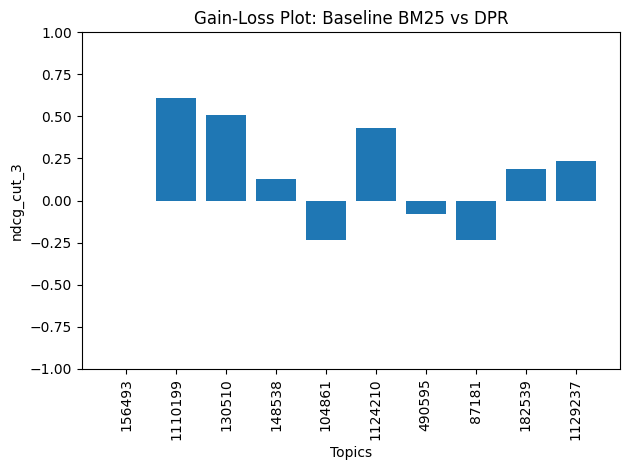

In [67]:
plot_gain_loss("runs/bm25-k=1.3-b=0.75.run",
               "runs/dpr_retrieval.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: Baseline BM25 vs DPR")

#### Gain-Loss Plot between Baseline BM25 and TILDEv2

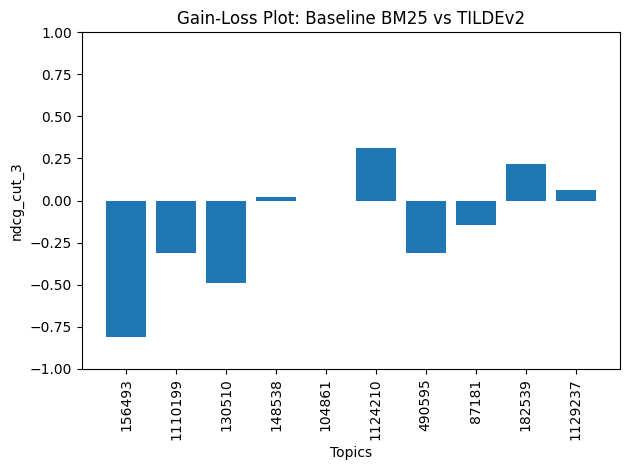

In [68]:
plot_gain_loss("runs/bm25-k=1.3-b=0.75.run",
               "runs/tildev2_retrieval.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: Baseline BM25 vs TILDEv2")

#### Gain-Loss Plot between Baseline BM25 and DPR with Pointwise Reranking

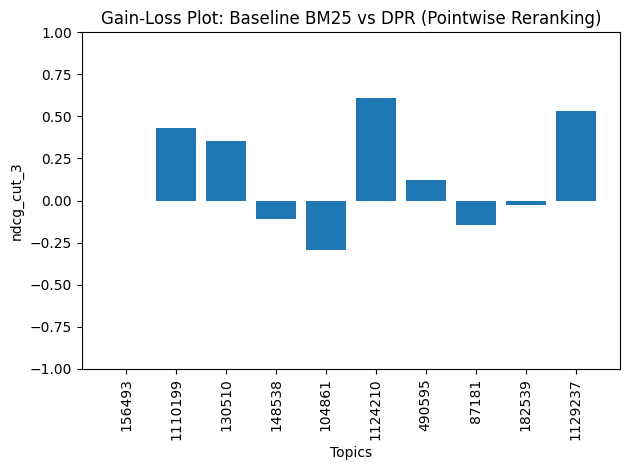

In [12]:
plot_gain_loss("runs/bm25-k=1.3-b=0.75.run",
               "runs/dpr_pointwise.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: Baseline BM25 vs DPR (Pointwise Reranking)")

#### Gain-Loss Plot between Baseline BM25 and DPR with Pairwise Reranking

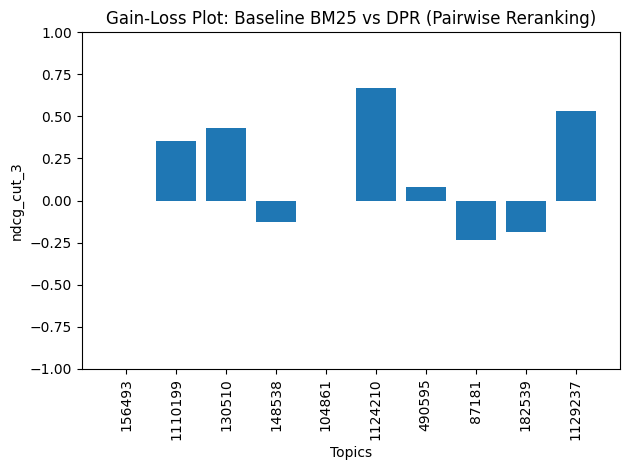

In [4]:
plot_gain_loss("runs/bm25-k=1.3-b=0.75.run",
               "runs/dpr_pairwise.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: Baseline BM25 vs DPR (Pairwise Reranking)")

#### Gain-Loss Plot between DPR and DPR with Pointwise Reranking

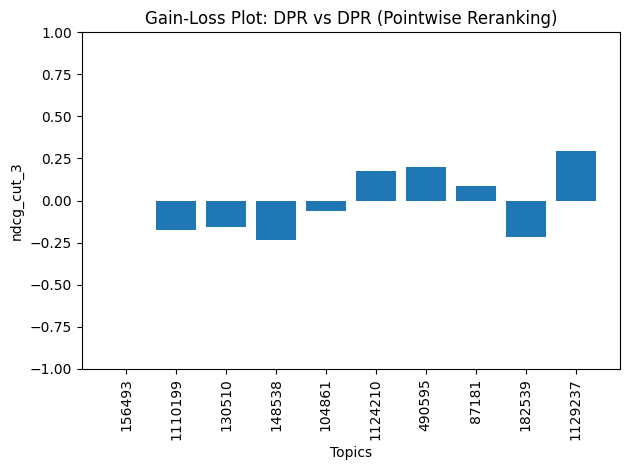

In [23]:
plot_gain_loss("runs/dpr_retrieval.run",
               "runs/dpr_pointwise.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: DPR vs DPR (Pointwise Reranking)")

#### Gain-Loss Plot between DPR and DPR with Pairwise Reranking

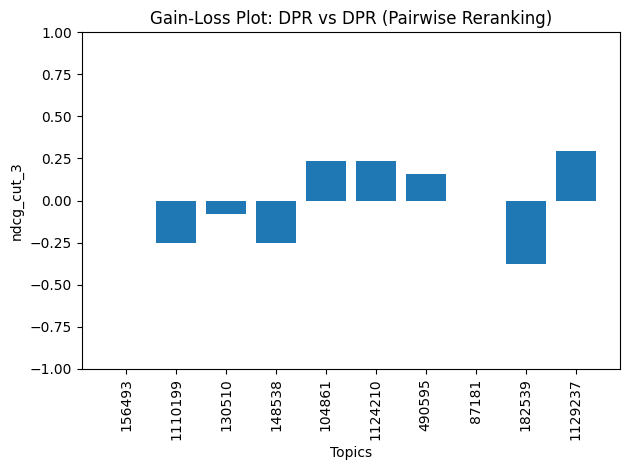

In [24]:
plot_gain_loss("runs/dpr_retrieval.run",
               "runs/dpr_pairwise.run",
               QRELS,
               "ndcg_cut_3",
               "Gain-Loss Plot: DPR vs DPR (Pairwise Reranking)")

### Discussions

1. Comment on **trends and differences** observed in your results. Is there a method that **consistently outperforms** others on all the queries for the dataset?

The table below summarises the nDCG@3 metric used to evaluate the BM25, DPR and TILDEv2 runs retrieved. The nDCG@3 metric will focus on the top 3 results retrieved by each method, telling us how effective the retrieval methods are at placing the most relevant documents at the top 3 positions in the retrieved ranked list result. Additionally, the results of the statistical significance tests when comparing DPR and TILDEv2 to the baseline BM25 run is also displayed. DPR with pointwise and pairwise reranking from the bonus tasks and their significance against BM25 is also included.

Table 1:
|           Method          |  NDCG@3 | P Value (Compared to Baseline BM25) | Statistical Significance (p < 0.05) |
|:-------------------------:|:-------:|:-----------------------------------:|:-----------------------------------:|
|    BM25 (k=1.3, b=0.75)   | 0.53323 |                 N/A                 |                 N/A                 |
|             DPR           | 0.68859 |               0.13366               |           Not Significant           |
|           TILDEv2         | 0.38662 |               0.20711               |           Not Significant           |
| DPR (Pointwise Reranking) | 0.68009 |               0.17263               |           Not Significant           |
| DPR (Pairwise Reranking)  | 0.68397 |               0.17113               |           Not Significant           |

Here, we can observe that out of the three standard retrieval methods of BM25, DPR and TILDEv2, DPR was able to obtain the highest nDCG@3 metric, with the baseline BM25 run being the second-most effective and TILDEv2 being the least effective. To analyse whether these differences in retrieval performance were statistically significant, the paired t-test was performed by considering BM25 as the baseline, and comparing the results of DPR and TILVEv2 to those of BM25. For DPR vs BM25, the table above shows that the p-value was 0.13366, and by considering a significance threshold of p < 0.05 as significant, this shows that the improvement in results by DPR when compared to BM25 were not significant. Similarly, comparing the results of TILDEv2 to BM25, we can again notice that the p-value of 0.20711 is greater than the threshold of 0.05, meaning the decrease in results by TILDEv2 when compared to BM25 was also not significant. Therefore, comparing the three standard retrieval methods, although there are differences in the nDCG@3 evaluation metric used, the t-test indicates these results could have been the result of random chance. However, we can notice that the p-value for DPR was lower than that for TILDEv2. This could perhaps mean that the significance of the DPR results was greater than the significance of the TILDEv2 results.

The reason behind why DPR may have outperformed the baseline BM25 is that DPR uses a LLM to generate embeddings that are optimised for semantic similarity comparisons between documents and queries. This means that DPR is able to make comparisons by capturing the meaning behind all words in the documents/queries, and can therefore more effectively make comparisons and retrieve documents which are relevant to the query. Meanwhile, BM25 is term-based and relies of words to match exactly and term frequency, which cannot capture the meaning behind the words in scenarios where a document might phrase things differently to phrasing used in the query. The reason why TILDEv2 underperforms both DPR and the baseline BM25 may be that since TILDEv2 takes each term in the query and finds documents that contains these terms, it is unable to perform semantic matching and understand the context of a term within the entire query and document, resulting in worse performance than DPR since it is also searching for exact keyword matches like BM25. Furthermore, since TILDEv2 calculates weights of terms in documents to score the relevance of a document to a query, it would be possible that certain terms present in the query are highly weighted in a document, but may not have the same importance in the query itself. Furthermore, in situations where the same term might be present in a query and document, but in different contexts, TILDEv2 is unable to differentiate between the contexts, leading to worse results than both BM25 and DPR.

Now, to consider the reranking methods implemented for the bonus task, we can perform the same paired t-test to compare DPR with pointwise and pairwise reranking against the baseline BM25. Considering DPR with pointwise reranking against BM25, we find a p-value greater than 0.05 of 0.17263, which again indicates no statistical significance. Similarly for DPR with pairwise reranking against BM25, the p-value of 0.17113 is larger than the significance threshold of p < 0.05, showing no significance either. Considering the nDCG@3 metrics achieved by the two reranking methods, we find scores of 0.68009 and 0.68397 for pointwise and pairwise reranking, respectively. This indicates that, for DPR, pairwise reranking was able to perform better than pointwise reranking, which is expected since the reranker can make decisions by comparing documents to each other rather than only considering if a certain document is related to the query. However, the run using DPR with no reranking at all achieved a nDCG@3 of 0.68859, greater than both reranking strategies implemented. This means that the use of a reranking strategy actually caused a decrease in performance, so both reranking strategies did not provide any value. One reason this may have happened is that the LLM used for the reranking strategies did not have enough domain-specific tuning since it just a TinyLLama chatbot rather than a model specifically designed for identifying relevance between queries and passages. Additionally, since the encoder used for DPR implementation was specifically tuned for DPR, the BERT encoder would have already been very capable of identifying relevance between documents and queries. However, when the reranking strategies which were just using a general chat bot for evaluation were applied to the already well-optimised DPR method, these strategies reordered the documents in a way that worsened the results achieved by DPR itself.

To understand whether the differences in performance between DPR with and without reranking applied was significant, statistical significance tests were also applied, and the results are summarised below.

Table 2:
|            Method            | P Value (Compared to standard DPR) | Statistical Significance (p < 0.05) |
|:----------------------------:|:----------------------------------:|:-----------------------------------:|
| DPR with Pointwise Reranking |               0.89046              |           Not Significant           |
|  DPR with Pairwise Reranking |               0.95206              |           Not Significant           |

In the table above, we can see that the p-values when comparing DPR with no reranking to DPR with pointwise and pairwise reranking were 0.89046 and 0.95206, respectively. Again, both these values are much larger than the threshold of 0.05, indicating no statistical significance in these results. Therefore, it could mean that the increase in nDCG@3 score after reranking was caused by random chance.

Considering the gain-loss plots created for the baseline BM25 vs DPR, we can observe that in almost all queries out of the 10 queries performed, DPR performed better quite significantly, though BM25 was able to slightly outperform DPR on queries 104861, 490595 and 87181. Both BM25 and DPR had the same performance on query 156493. This is in line wih expectations, as we have already seen that DPR is much more effective than BM25 in Table 1. Similarly, for BM25 vs TILDEv2, we can see that in almost all cases apart from queries 148538, 1124210, 182539, and 1129237, BM25 had a much larger gain in performance, and the queries where TILDEv2 did have an improvement over BM25 only had relatively small gains. Interestingly, we see that in the case of query 104861, there is no difference, so both BM25 and TILDEv2 had the exact same performance. Observing the gain-loss plots for BM25 vs DPR (Pointwise Reranking) and BM25 vs DPR (Pairwise Reranking), we can also notice that the gain-loss plots are quite similar, with both plots seeing an increase or decrease when the other plot also experiences an increase/decrease. The only exception to this is query 104861, where for pointwise there is a decrease in performance while pairwise saw no difference in performance, when compared to BM25. We can also notice a pattern where the magnitude of differences for both pointwise and pairwise reranking when compared to BM25 are very similar as well. This indicates that the results from the two reranking methods are quite similar. Finally, considering the two gain-loss plots for DPR vs DPR (Pointwise Reranking) and DPR vs DPR (Pairwise Reranking), we can also observe that the trends in which queries saw an increase or decrease in performance are quite similar.

Taking a perspective over all gain-loss plots generated, we can see that query 156493 saw almost no change in nDCG@3 metric when another method was compared to BM25, except for TILDEv2 which led to a decrease in performance. This likely means that 156493 and the documents to retrieve to answer it were quite similar and easily retrievable, as BM25 was able to obtain the same nDCG@3 score to DPR. Conversely, query 87181 saw a decrease in performance in nearly all comparisons, meaning that BM25 was likely able to perform on this query quite well, and that any additional methods considering semantics were not helpful in answering this query. Query 1124210, however, saw a significant increase in performance in almost every gain-loss plot, indicating that more complex methods were more effective for answering this query.

Overall, by observing the nDCG@3 metrics in Table 1, as well as all of the gain-loss plots created above, we can see that there is no method that consistently outperforms every other method on all queries in the dataset. However, we can notice that the standard DPR method (with no reranking) was the closest to outperforming all other methods, as it had the highest nDCG@3 score out of all others. Its gain-loss plot also showed significant improvements across almost every query when compared to BM25, and any decreases in performance were relatively small. When compared to its own results but with added pointwise/pairwise reranking, the gain-loss plots show any increases/decreases in performance had small magnitudes, and also had a relatively even number of these. Therefore, standard DPR with no reranking performed the best when compared too all other methods, though it was not capable of consistently outperforming on all queries.

-------

## Task-2: *Exploring Generative models*
We now explore generative models in information retrieval applications by implementing RAG, and designing methods to evaluate RAG responses.

### Implementation of Retrieval Augmented Generation (RAG) pipeline with TinyLlama

In this section, I will implement a Retrieval Augmented Generation (RAG) pipeline using the TinyLLama chat LLM. RAG is a technique that uses a large language model to answer questions. However, instead of simply passing a query directly to the LLM, RAG has the addition of including context documents that can help the LLM understand background knowledge it can use to answer a specific query. These context documents give the LLM access to external knowledge that it may not have been exposed to during training, allowing it to output more accurate answers. To determine what documents are included as context to the LLM, we can use a retrieval method, such as those we have implemented in the above Task-1 (BM25, DPR or TILDEv2). The steps needed for implementing a RAG pipeline for a given query are:
1. Perform retrieval (using IR methods such as BM25, DPR or TILDEv2)
2. Taking the top k documents retrieved in step 1 (in this project, we will only be using the top 3)
3. Providing the retrieved documents in step 3, along with the query, to the LLM and prompting it to answer the query.

We can then expect the resulting response from the LLM to answer the query sufficiently, with accurate background information to justify its response.

In [16]:
# Change device to either cuda or cpu since mps implementation of certain functionality for TinyLlama is broken.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [108]:
# Loading model and tokenizer
llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(llm).to(device)
tokenizer = AutoTokenizer.from_pretrained(llm)
tokenizer.padding_side = "left" # Set padding to the left
tokenizer.pad_token = tokenizer.bos_token # Use the beginning-of-sequence token for padding

In [109]:
def tiny_llama_rag(retrieval_run_file, save_path):
    # Read in queries to perform RAG on
    queries = []
    with open(QUERIES, "r") as f:
        for line in f.readlines():
            parts = line.split("\t") # TSV stores in order of: topic ID, query
            queries.append((parts[0], parts[1].strip()))

    # Read retrieved files from the retrieval run
    with open(retrieval_run_file, "r") as f:
        run_file = pytrec_eval.parse_run(f)

    # Read corpus as DataFrame to get passages to pass to LLM
    corpus = pd.read_json(path_or_buf=CORPUS, lines=True)

    data = []

    # Perform RAG on all queries
    for query_id, query in queries:
        # Get top documents retrieved using BM25/DPR/TILDEv2 to provide context to LLM
        context = ""
        i = 0
        for doc_id, score in run_file[query_id].items():
            document = corpus[corpus["id"] == int(doc_id)]["contents"].values[0]
            context += "\n" + document
            i += 1
            if i == 3:
                break # Only consider top 3 retrieved documents as context for LLM

        rag_input = f"Using the following context, answer the question: {context}\nUser Question: {query}"

        # Directly generating an answer from the LLM
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": rag_input},
        ]

        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
        input_len = input_ids.shape[1]

        # Generate the model's response
        output_ids = model.generate(
            input_ids,
            max_new_tokens=256,
            num_return_sequences=1,
            temperature=1
        )

        # Decode the generated response, skipping the input part to only get the model's answer
        response = tokenizer.decode(output_ids[0][input_len:], skip_special_tokens=True)

        data.append({"query_id": query_id, "query": query, "response": response})

        print(f"ID: {query_id}, Query: {query}")
        print(f"RAG Response: {response}")
        print("------------------------")

    # Write to file
    with open(save_path, 'w') as f:
        json.dump(data, f, indent=4)

#### RAG using BM25 for Retrieval

In [110]:
tiny_llama_rag("runs/bm25-k=1.3-b=0.75.run", "rag/bm25-tinyllama.json")

ID: 156493, Query: do goldfish grow
RAG Response: The given context states that a goldfish will grow to the depth of the water it is kept in if the tank is not large enough to allow it to grow. This means that if the tank is not large enough to accommodate the fish's natural growth, it will not be able to reach the depth at which it can grow and thrive. This can cause the fish to become unhealthy and die, as it will not be able to maintain its proper growth and development. The fancy goldfish, which are not as large as the common/comet/shubunkin/feeder goldfish, are not considered to grow to the size of their tank.
------------------------
ID: 1110199, Query: what is wifi vs bluetooth
RAG Response: Bluetooth vs. WiFi - Range: Bluetooth has a maximum range of 30 meters, while Wi-Fi can extend up to 100 meters.

WiFi vs. Bluetooth - Devices Connected: Bluetooth can connect up to 7 devices at a time, while Wi-Fi can accommodate several devices at a time.

Buspar vs. Zoloft differences:

1

#### RAG using DPR for Retrieval

In [20]:
tiny_llama_rag("runs/dpr_retrieval.run", "rag/dpr-tinyllama.json")

ID: 156493, Query: do goldfish grow
RAG Response: The context provided does not directly answer the question "How fast do goldfish grow?" However, it does provide some information about goldfish and their growth patterns. Goldfish are known as indeterminate growers, meaning they can grow to any size within their enclosure. This means that proper care and water quality can help prevent goldfish from growing beyond their intended size. While there is an element of truth to this, it is not as innocent as it sounds and is related more to water quality than tank size. Goldfish are not fixed in size and can continue to grow as long as they have access to food and water.
------------------------
ID: 1110199, Query: what is wifi vs bluetooth
RAG Response: The context suggests that Wi-Fi and Bluetooth are complementary in their applications and usage. Wi-Fi is usually access point-centered, with an asymmetrical client-server connection with all traffic routed through the access point, while Blu

#### RAG using TILDEv2 for Retrieval

In [21]:
tiny_llama_rag("runs/tildev2_retrieval.run", "rag/tildev2-tinyllama.json")

ID: 156493, Query: do goldfish grow
RAG Response: The common goldfish, also known as feeder fish, is a type of goldfish with no other differences from their ancestors other than their color. Goldfish are a form of domesticated wild carp and are a close relative of koi. Most varieties of fancy goldfish were derived from this simple breed. Common goldfish come in a variety of colors including red, orange, yellow, white, black, and calico goldfish. Fancy goldfish, on the other hand, are a close relative of koi and come in a variety of colors including red, orange, yellow, white, black, and calico goldfish.
------------------------
ID: 1110199, Query: what is wifi vs bluetooth
RAG Response: Devices may implement either the LE or the Classic Bluetooth systems, or they may implement both. Devices implementing both are called Bluetooth 4.0 dual mode devices. The Bluetooth Smart logo was introduced in 2011. If a device is Bluetooth Smart Ready, it is compatible with both Classic and Bluetooth 

-------

### RAG Evaluation Methods

In this section, we will explore methods that can be used for evaluating the above results generated from Retrieval Augmented Generation. In particular, the evaluation methods that will be implemented are BLEU and ROGUE.

To evaluate the responses generated by RAG, it is necessary for there to be reference responses to compare how well the RAG method performs. To create reference responses, I use ChatGPT (with no given context from the sampled MSMarco corpus), validated the responses manually, and edited any unnecessary or incorrect information. Since ChatGPT by OpenAI is trained on a significant amount of data, it already has a good understanding of general information like those asked in the queries. By further fact-checking the responses manually, we can be confident the reference responses being used are accurate and can answer the query questions correctly.

In [5]:
# Write reference responses
reference_responses = {
    "156493": "Yes, goldfish can grow quite large. They are capable of reaching over 18 inches and 10 pounds. Even the smallest breeds can reach between 4 and 7 inches. Fancy goldfish typically range between 6-8 inches long, while single tail goldfish can grow to 10-12 inches.",
    "1110199": "Wi-Fi and Bluetooth are both wireless communication technologies, but they are designed for different purposes and operate in different ways. Wi-Fi provides high-speed internet access over a larger range (up to 300 feet) and supports many devices, but consumes more power. Bluetooth is designed for short-range (up to 30 feet), low-power connections between devices like headphones and keyboards, with slower data transfer speeds. Wi-Fi is ideal for networking and internet use, while Bluetooth is best for device-to-device communication.",
    "130510": "A declaratory judgment is a legal determination by a court that resolves uncertainty or disputes regarding the rights, obligations, or legal status of parties in a specific situation, without ordering any specific action or awarding damages. It provides clarity on the interpretation of laws or legal relationships, allowing parties to understand their legal standing.",
    "148538": "An RN (Registered Nurse) is a licensed healthcare professional who can practice nursing, while a BSN (Bachelor of Science in Nursing) is a four-year academic degree in nursing. RNs can earn their licensure through various educational paths, including an ADN (Associate Degree in Nursing), diploma programs, or a BSN.",
    "104861": "The cost of interior concrete flooring typically ranges from $5 to $25 per square foot, including both materials and installation. Basic concrete flooring materials cost about $2 to $6 per square foot, while decorative finishes can add $3 to $15. Installation costs vary from $3 to $10 per square foot, depending on complexity and regional labor rates. Factors influencing the overall cost include the type of finish, preparation work required, and geographic location.",
    "1124210": "Tracheids are part of vascular plants. They are elongated cells found in the xylem, which is responsible for water and nutrient transport in plants. Tracheids play a crucial role in providing structural support and facilitating the movement of water through the plant.",
    "490595": "RSA (Rivest-Shamir-Adleman) is a public-key cryptographic system that uses two keys: a public key for encryption and a private key for decryption. Its security relies on the difficulty of factoring large prime numbers. RSA is commonly used for secure data transmission, digital signatures, and authentication in various security protocols.",
    "87181": "Left ventricular hypertrophy (LVH) is the thickening of the left ventricle walls, commonly caused by chronic high blood pressure (hypertension) and conditions like aortic stenosis and cardiomyopathy. Other contributing factors include intense athletic training, obesity, diabetes, sleep apnea, genetic predispositions, and chronic kidney disease.",
    "182539": "A monotonic function is one that is either entirely non-increasing or non-decreasing. An example of a monotonically increasing function is: f(x) = 2x + 3 (increases as x increases). An example of a monotonically decreasing function is: g(x) = -x + 5 (decreases as x increases).",
    "1129237": "Hydrogen becomes a liquid below its boiling point of -252.87°C (-423.17°F) at standard atmospheric pressure. Below this temperature, hydrogen exists in a liquid state, and at temperatures lower than -259.16°C (-434.49°F), it solidifies."
}

#### BLEU: Bilingual Evaluation Understudy

The first method that will be implemented is the Bilingual Evaluation Understudy (BLEU) metric. BLEU compares the generated RAG answers against reference answers, treating the reference answers as the “ground truth.”

To compare the generated answer with the reference, BLEU first tokenizes both texts, breaking them down into individual words and converting all words to lowercase. This is important since in later steps, BLEU will perform comparisons by searching for exact-matches of words, so making all words lowercase will help to avoid case-sensitivity issues. After tokenization, BLEU measures the overlap between n-grams in the generated and reference texts. An n-gram consists of a series of consecutive tokens, where for each token, the next n tokens are considered as part of the n-gram. For example, a unigram is a single word, a bigram consists of two consecutive words, etc. Using n-grams is beneficial because it captures matches between phrases rather than just standalone words, making it a more robust measure of similarity between the generated and reference texts. The metric then calculates the precision, which is the proportion of matching n-grams between the generated and reference texts. For each of the different n-gram lengths, BLEU calculates the geometric mean of precision scores to balance exact word matches and longer phrase matches.

To prevent short generated responses from achieving high scores solely based on a few common words, BLEU applies a brevity penalty. This penalty reduces the score if the generated text is significantly shorter than the reference, discouraging very short responses that might have a high word overlap but fail to capture the full content.

So, the final BLEU score is calculated as the product of the geometric mean of the precision scores and the brevity penalty. The BLEU score ranges from 0 to 1, where a higher score indicates that the generated response is more similar to the reference response.

*Reference for BLEU:* https://medium.com/nlplanet/two-minutes-nlp-learn-the-bleu-metric-by-examples-df015ca73a86

In [6]:
def evaluate_bleu(rag_json, n=4):
    # Load in RAG-generated responses
    with open(rag_json, 'r') as file:
        data = json.load(file)

    bleu_scores = []

    # Consider all queries and their generated response
    for response in data:
        reference_tokens = reference_responses[response["query_id"]].lower().split()
        generated_tokens = response["response"].lower().split()

        # Taking n-grams
        reference_ngrams = [[tuple(reference_tokens[j:j+i]) for j in range(len(reference_tokens)-i+1)] for i in range(1, n+1)]
        generated_ngrams = [[tuple(generated_tokens[j:j+i]) for j in range(len(generated_tokens)-i+1)] for i in range(1, n+1)]

        precisions = []
        for i in range(n):
            ref_counter = Counter(reference_ngrams[i])
            gen_counter = Counter(generated_ngrams[i])
            matches = sum((gen_counter & ref_counter).values())
            precision = matches / len(generated_ngrams[i]) if generated_ngrams[i] else 0
            precisions.append(precision)

        # Brevity penalty
        brevity_penalty = np.exp(1 - (len(reference_tokens) / len(generated_tokens)))
        if len(generated_tokens) > len(reference_tokens):
            brevity_penalty = 1

        # Calculate BLEU score using geometric mean of precision scores
        if all(p == 0 for p in precisions):
            bleu_scores.append(0)

        geo_mean = np.exp(np.mean(np.log([p for p in precisions if p > 0])))  # Geometric mean
        bleu_scores.append(brevity_penalty * geo_mean)

    return bleu_scores

In [7]:
bm25_rag_bleu = evaluate_bleu("rag/bm25-tinyllama.json")
print("Average BLEU score for RAG with BM25:", sum(bm25_rag_bleu)/10)

Average BLEU score for RAG with BM25: 0.05615762844371665


In [8]:
dpr_rag_bleu = evaluate_bleu("rag/dpr-tinyllama.json")
print("Average BLEU score for RAG with DPR:", sum(dpr_rag_bleu)/10)

Average BLEU score for RAG with DPR: 0.058246708967301844


In [9]:
tildev2_rag_bleu = evaluate_bleu("rag/tildev2-tinyllama.json")
print("Average BLEU score for RAG with TILDEv2:", sum(tildev2_rag_bleu)/10)

Average BLEU score for RAG with TILDEv2: 0.05478970510925374


#### ROGUE: Recall-Oriented Understudy for Gisting Evaluation

The Recall-Oriented Understudy for Gisting Evaluation (ROUGE) metric is another evaluation method that compares the quality of generated responses by finding matches between the generated text and reference text. Compared to BLEU which focuses on the precision between generated and reference texts (how many words in the generated response appear in the reference), ROUGE focuses more on recall, measuring how much of the reference text is captured by the generated response.

Here, we will be implementing the ROUGE-N variant, which evaluates the overlap between n-grams in the generated and reference texts, similar to BLEU that was implemented previously. ROUGE-N is calculated by counting the number of n-grams from the reference that appear in the generated text and dividing it by the total number of n-grams in the reference. This focuses on recall, meaning it measures how much of the important information in the reference text is successfully captured by the generated text.

Unlike the precision-based BLEU metric, ROUGE will prefer generated responses that reproduce more of the relevant content from the reference, even if they include some additional, non-matching words. For example, if a generated response contains many of the important phrases found in the reference text, it will achieve a higher ROUGE score, even if it includes extra or unrelated content.

The final ROUGE-N score ranges from 0 to 1, where a higher score indicates that the generated response captures a larger portion of the key information from the reference text.

*Reference for ROUGE:* https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499

In [10]:
def evaluate_rouge(rag_json, n=2):
    # Load in RAG-generated responses
    with open(rag_json, 'r') as file:
        data = json.load(file)

    rouge_scores = []

    # Consider all queries and their generated response
    for response in data:
        reference_tokens = reference_responses[response["query_id"]].lower().split()
        generated_tokens = response["response"].lower().split()

        rouge_n_scores = []
        for i in range(1, n+1):
            # Generate n-grams for reference and generated tokens
            reference_ngrams = [tuple(reference_tokens[j:j+i]) for j in range(len(reference_tokens)-i+1)]
            generated_ngrams = [tuple(generated_tokens[j:j+i]) for j in range(len(generated_tokens)-i+1)]

            # Count n-grams
            ref_counter = Counter(reference_ngrams)
            gen_counter = Counter(generated_ngrams)

            # Calculate number of overlapping n-grams (recall)
            matches = sum((gen_counter & ref_counter).values())
            recall = matches / len(reference_ngrams) if reference_ngrams else 0

            rouge_n_scores.append(recall)

        avg_rouge = np.mean(rouge_n_scores)
        rouge_scores.append(avg_rouge)

    return rouge_scores

In [11]:
bm25_rag_rogue = evaluate_rouge("rag/bm25-tinyllama.json")
print("Average ROGUE score for RAG with BM25:", sum(bm25_rag_rogue)/10)

Average ROGUE score for RAG with BM25: 0.2189333254116325


In [12]:
dpr_rag_rogue = evaluate_rouge("rag/dpr-tinyllama.json")
print("Average ROGUE score for RAG with DPR:", sum(dpr_rag_rogue)/10)

Average ROGUE score for RAG with DPR: 0.3034144617843537


In [13]:
tildev2_rag_rogue = evaluate_rouge("rag/tildev2-tinyllama.json")
print("Average ROGUE score for RAG with TILDEv2:", sum(tildev2_rag_rogue)/10)

Average ROGUE score for RAG with TILDEv2: 0.14407980476138207


### [Bonus Task] Additional Evaluation Methods for RAG
In this section, I implement two additional evaluation methods for the bonus task.

#### Embedding Similarity Measure

In this section, we will implement an evaluation metric based on the cosine similarity of sequence embeddings to assess the quality of generated responses. Unlike the previously-implemented traditional evaluation methods like BLEU and ROUGE that rely on token-level comparisons (such as n-grams), this approach focuses on capturing the overall semantic similarity between the entire generated response and the reference response. Since BLEU and ROUGE focus on finding tokens that match, they would struggle at evaluating responses that may paraphrase or use different words within the same context. In this method, using a LLM to generate embeddings means that this problem with BLEU and ROGUE no longer affect our evaluation of the RAG results.

First, the generated and reference responses are transformed into sequence embeddings. These embeddings represent the entire passage/sequence as a dense vector that captures its overall meaning. This transformation is done using a pre-trained BERT model. These embeddings encapsulate the contextual meaning of the whole text, taking into account word order and relationships between words within the sequence.

Once the sequence embeddings for both the generated and reference texts are obtained, we calculate the cosine similarity between the two vectors. Cosine similarity measures the cosine of the angle between two vectors, resulting in a score between -1 and 1, where:

- 1 indicates that the embeddings are identical (i.e., the generated text is semantically very similar to the reference text)
- 0 indicates no similarity
- -1 indicates complete dissimilarity

By performing cosine similarity at the sequence level, this approach can evaluate how well the generated text conveys the same meaning as the reference text.

This method is similar to the BertScore method (https://arxiv.org/abs/1904.09675), though BertScore computes similarities between tokens rather than the entire sequence. My implementation here only compares similarities between the embeddings for the entirety of the reference/generated responses, and was inspired by the implementation of DPR.

In [14]:
def evaluate_embedding_sim(rag_json, tokenizer, encoder):
    # Load in RAG-generated responses
    with open(rag_json, 'r') as file:
        data = json.load(file)

    bert_scores = []

    for response in data:
        # Tokenise responses
        reference_tokens = tokenizer([reference_responses[response["query_id"]]], return_tensors="pt", padding="longest", truncation=True).to(device)
        generated_tokens = tokenizer([response["response"]], return_tensors="pt", padding="longest", truncation=True).to(device)

        # Get embeddings for comparison
        ref_embedding = encoder(**reference_tokens)[0][:, 0, :].detach().cpu().numpy()
        gen_embedding = encoder(**generated_tokens)[0][:, 0, :].detach().cpu().numpy()

        # Find cosine similarity
        similarity = cosine_similarity(ref_embedding, gen_embedding)[0][0]

        bert_scores.append(similarity)

    return bert_scores

In [17]:
# Initialize the tokenizer and model
encoder = BertModel.from_pretrained("ielabgroup/StandardBERT-DR").eval()
tokenizer = BertTokenizer.from_pretrained("ielabgroup/StandardBERT-DR")
encoder.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
bm25_rag_embed_sim = evaluate_embedding_sim("rag/bm25-tinyllama.json", tokenizer, encoder)
print("Average Embedding Similarity score for RAG with BM25:", sum(bm25_rag_embed_sim)/10)

Average Embedding Similarity score for RAG with BM25: 0.8824721097946167


In [19]:
dpr_rag_embed_sim = evaluate_embedding_sim("rag/dpr-tinyllama.json", tokenizer, encoder)
print("Average Embedding Similarity score for RAG with DPR:", sum(dpr_rag_embed_sim)/10)

Average Embedding Similarity score for RAG with DPR: 0.9141989946365356


In [20]:
tildev2_rag_embed_sim = evaluate_embedding_sim("rag/tildev2-tinyllama.json", tokenizer, encoder)
print("Average Embedding Similarity score for RAG with TILDEv2:", sum(tildev2_rag_embed_sim)/10)

Average Embedding Similarity score for RAG with TILDEv2: 0.8088908851146698


#### LLM-Based Evaluation

Here, we will also implement an evaluation method that leverages a large language model (LLM) to assess the relevance and quality of generated responses from RAG (Retrieval-Augmented Generation). This method was inspired by the concept of LLM-as-a-judge, and takes an approach similar to pointwise reranking by prompting the LLM to evaluate the generated answers in the context of the query and a reference answer.

For each query and corresponding generated response from the RAG model, we compare it with the reference (ground truth) response. The LLM is given a structured prompt, where it is instructed to evaluate the generated passage. The prompt includes:

- The query (the original input question),
- The true answer (reference response),
- The generated passage (the response generated by RAG).

The LLM is prompted with a simple task: determine whether the generated passage is similar to the true answer and relevant to the query. If so, it should return “Yes,” otherwise “No.” The LLM, which is using the TinyLLama chatbot, will generate either a "Yes" or "No" to indicate how well the generated response aligns with the reference. The steps to take for this evaluation method are:
1.	We tokenize the LLM input (including the query, reference and generated RAG passage), and generate the necessary sequence to pass to the model.
2.	After the LLM processes the input, we focus on the “Yes” token, which is the desired output if the passage is semantically similar to the reference.
3.	The probability of the “Yes” token is calculated, allowing us to compute the likelihood that the LLM considers the generated response to be relevant and correct.

Since the LLM will generate probabilities of which token should come next, the probability of the next token being "Yes" will be the score the LLM gives to the RAG response.

This method differs from the methods implemented previously. Traditional token-based metrics like BLEU and ROUGE, as mentioned before, are focussed entirely on finding matching keywords, and are unable to consider the context of the passages being evaluated. Additionally, the previous Embedding Similarity measure using Cosine similarity only measures the similarity in context between the reference answer and generated answer. Thus, it is unable to judge its relevance to the query being asked and how correct the response was. This LLM-based method offers an evaluation approach that introduces an element of contextual understanding and also leverages the LLM’s understanding of language to score the generated response, allowing it to check the generated response against an "answer", relative to the question being asked. Additionally, it can act like a human evaluator would, which can be crucial in tasks such as RAG evaluation where the generated text is expected to reflect deeper understanding or paraphrasing, rather than exact lexical matches.

In [21]:
# Change device to either cuda or cpu since mps implementation of certain functionality for TinyLlama is broken.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [22]:
llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(llm).to(device)
tokenizer = AutoTokenizer.from_pretrained(llm)

In [23]:
def evaluate_rag_llm(rag_json):
    # Load in RAG-generated responses
    with open(rag_json, 'r') as file:
        data = json.load(file)

    llm_scores = []

    for response in data:
        generated_rag = response["response"]
        query = response["query"]
        reference = reference_responses[response["query_id"]]

        # Get messages to pass to LLM
        message = [
            {"role": "system", "content": "You are a helpful assistant. If the passage is similar to the true answer and also relevant to the question, answer Yes, otherwise answer No."},
            {"role": "user", "content": f"Question: {query} \nTrue Answer: {reference} \nPassage: {generated_rag}"},
        ]

        # Tokenize and prepare input
        text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True) + ' The answer is ']
        input_ids = tokenizer(text, return_tensors="pt", padding=True).to(device)

        # Token ID for "Yes"
        yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)

        # Generate output
        output_ids = model(
            **input_ids,
            output_hidden_states=False,
            return_dict=True
        )

        logits = output_ids.logits[:, -1, :]

        # Compute softmax probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get probabilities for the "Yes" token
        yes_probabilities = probabilities[:, yes_token_id]
        llm_scores.append(yes_probabilities[0].item())

    return llm_scores

In [24]:
bm25_rag_llm_eval = evaluate_rag_llm("rag/bm25-tinyllama.json")
print("Average LLM score for RAG with BM25:", sum(bm25_rag_llm_eval)/10)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Average LLM score for RAG with BM25: 0.5059986910847556


In [25]:
dpr_rag_llm_eval = evaluate_rag_llm("rag/dpr-tinyllama.json")
print("Average LLM score for RAG with DPR:", sum(dpr_rag_llm_eval)/10)

Average LLM score for RAG with DPR: 0.5040546581149101


In [26]:
tildev2_rag_llm_eval = evaluate_rag_llm("rag/tildev2-tinyllama.json")
print("Average LLM score for RAG with TILDEv2:", sum(tildev2_rag_llm_eval)/10)

Average LLM score for RAG with TILDEv2: 0.4670465316299456


### Evaluation

In this section, we will analyse the results generated from RAG, and investigate correlations to see how retrieval techniques can affect RAG performance across the different implemented evaluation strategies.

#### Analysis of Results

Here, I will analyse the results of the RAG pipeline with all three retrievers (BM25, DPR and TILDEv2). The three tables below summarise the RAG-generated response, as well as the corresponding scores for each of the 4 implemented evaluation methods. Obeserving the results in general, it is evident that the overall performance is not ideal, as many of the generated answers do not directly and clearly answer the question. There are also multiple examples of the LLM used in RAG not completing its response. An example of this is the RAG pipeline using DPR as the retriever, where the response to the query "difference between rn and bsn" cuts off abruptly. Overall, however we can see that the RAG-generated responses using the stronger retrievers give much stronger responses. Considering RAG using BM25 and RAG using DPR and the query "cost of interior concrete flooring", the BM25 result gives pricing from a specific company (and this information was likely retrieved by the BM25 retriever), whilst the DPR result gives a much more general answer that explains prices ranges depending on area being covered and the material being used. This is expected behaviour, as a stronger base retriever would be able to select documents that are more suited to the query, and thus helps the LLM answer the query much more accurately.


##### Results for **RAG with BM25 Retriever**:
| Query                                       | Generated Response                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | BLEU     | ROGUE   | Embedding Cosine Similarity | LLM Evaluation |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|---------|-----------------------------|----------------|
| do goldfish grow                            | The given context states that a goldfish will grow to the depth of the water it is kept in if the tank is not large enough to allow it to grow. This means that if the tank is not large enough to accommodate the fish's natural growth, it will not be able to reach the depth at which it can grow and thrive. This can cause the fish to become unhealthy and die, as it will not be able to maintain its proper growth and development. The fancy goldfish, which are not as large as the common/comet/shubunkin/feeder goldfish, are not considered to grow to the size of their tank.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0.046996 | 0.16717 | 0.80634                     | 0.08670        |
| what is wifi vs bluetooth                   | Bluetooth vs. WiFi - Range: Bluetooth has a maximum range of 30 meters, while Wi-Fi can extend up to 100 meters.  WiFi vs. Bluetooth - Devices Connected: Bluetooth can connect up to 7 devices at a time, while Wi-Fi can accommodate several devices at a time.  Buspar vs. Zoloft differences:  1. Mechanism of action: Buspar is an antidepressant medication that works by reducing the activity of the serotonin and norepinephrine reuptake inhibitors (SNRIs) in the brain. Zoloft is an antidepressant medication that works by increasing the activity of the serotonin and norepinephrine reuptake inhibitors (SNRIs) in the brain. 2. Uses: Buspar is used to treat anxiety, panic disorder, and obsessive-compulsive disorder (OCD). Zoloft is used to treat depression, obsessive-compulsive disorder (OCD), and post-traumatic stress disorder (PTSD)                                                                                                                                                                                                                         | 0.15873  | 0.12821 | 0.81594                     | 0.61288        |
| definition declaratory judgment             | A declaratory judgment is a legal ruling that is conclusive and legally binding as to the present and future rights of the parties involved. It is not subject to appeal and cannot be challenged in court. The parties involved in a declaratory judgment may not seek another court resolution of the same legal issue unless they appeal the judgment. Common law and statutory law provide for the availability of a declaratory judgment. The same court may decline to grant a declaratory judgment if the basic requirements for an A Declaratory Judgment Action are met. Declaratory relief is a matter of district court discretion.                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0.06144  | 0.25105 | 0.94209                     | 0.85270        |
| difference between rn and bsn               | Yes, the difference between an RN and a BSN is that an RN is a title for a registered nurse, while a BSN stands for a Bachelor of Science in nursing. An RN is a licensed professional who has completed an accredited nursing program and has earned a registered nurse license. A BSN is a degree that prepares individuals to become licensed nurses.  The BSN is typically a four-year program that includes coursework in areas such as biology, chemistry, psychology, and healthcare management. Upon completion of the program, students are eligible to take the National Council Licensure Examination (NCLEX) to become licensed nurses.  An RN, on the other hand, is a title for a registered nurse who has completed an accredited nursing program and has earned a license to practice nursing. RNs are typically employed in a variety of settings, including hospitals, clinics, and home health care.  The BSN provides more opportunities for professional advancement and upward mobility, as it prepares individuals to take on more complex roles and responsibilities | 0.05862  | 0.40051 | 0.95259                     | 0.85204        |
| cost of interior concrete flooring          | Yes, Day's Concrete Floors, Inc is the name of the company that pours a lot of 3000 psi. concrete for interior concrete floors and 4000 psi concrete for exterior concrete. The concrete cost per yard of concrete is $92.00 for 3000 3/4 psi concrete and $100.00 for 4000 3/4 psi concrete. So, for 10 yards of concrete, the total cost is $1000.00 dollars U.S. Here in Maine.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0.04958  | 0.09599 | 0.83295                     | 0.79348        |
| tracheids are part of _____.                | The tracheids are part of the xylem in higher plants.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0.01273  | 0.13182 | 0.91665                     | 0.16321        |
| rsa definition key                          | RSA (Rivest, Shamir, and Adleman) encryption is a public-key encryption technology developed by RSA Data Security. The RSA algorithm is based on the difficulty in factoring very large numbers, and the RSA encryption algorithm uses prime factorization as the trap door for encryption. Deducing an RSA key takes a huge amount of time and processing power, and RSA is the standard encryption method for important data, especially data that's transmitted over the Internet.  To generate RSA key pairs for a Cisco device, you need to use the "rsa" command with the "key-label" argument and specify the usage-keys or general-keys keyword. Named key pairs allow you to have multiple RSA key pairs, enabling the Cisco IOS software to maintain a different key pair for each identity certificate.                                                                                                                                                                                                                                                                           | 0.05106  | 0.31739 | 0.89849                     | 0.76903        |
| causes of left ventricular hypertrophy      | The context of the question refers to medical information for Left ventricular hypertrophy, which is a condition where the heart muscle becomes thicker and enlarged. The causes of left ventricular hypertrophy can vary depending on the specific cause.  1. Hypertension: Hypertension is the most common cause of left ventricular hypertrophy. High blood pressure (hypertension) is a condition where the blood pressure is higher than normal. This can be caused by a variety of factors, including genetics, lifestyle, and environmental factors.  2. Aortic valve stenosis: Aortic valve stenosis is a condition where the valve that opens and closes the aorta (the main artery that supplies blood to the heart) becomes narrowed or blocked. This can cause left ventricular hypertrophy, as the increased workload of the heart muscle can lead to hypertrophy.  3. Left ventricular hypertrophy: Left ventricular hypertrophy can occur for a variety of reasons, including genetics, lifestyle, and environmental factors. Some of the causes of                           | 0.03011  | 0.30893 | 0.86597                     | 0.28634        |
| example of monotonic function               | To solidify our understanding of what a non-monotonic function is, let's consider what a non-monotonic function is. A non-monotonic function is a function that is not increasing or decreasing on different intervals of its domain. For example, consider our initial example f(x) equals x 2. A non-monotonic function is a function that maintains the order of functions value. As we all know that the variation in independent value also make the variation in functions value. A suitable example for this is non-monotonic functions or non-linear polynomials. Non-monotonic functions do not maintain the straight line in linear programming graph. This is also called the non-monotonic nature over the domain and real numbers. A non-monotonic function increases and decreases over the interval. Non-monotonic functions are not strictly monotonic, and we call them non-monotonic functions. For example, consider the function g(x) equals x 3: Notice the graph of g is not increasing everywhere. Therefore, this is a non-monotonic function.                       | 0.04168  | 0.25048 | 0.84632                     | 0.64355        |
| hydrogen is a liquid below what temperature | The temperature at which hydrogen becomes a liquid is 423.17 degrees below zero Fahrenheit.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 0.05064  | 0.13778 | 0.94733                     | 2.0331e-06     |

Analysing each of the responses and evaluation scores from RAG using BM25 as retriever (in order of table above):
1. The response does not directly answer directly answer whether goldfish themselves will grow, but instead talks about goldfish growth relative to its environment. Response is still relevant to the question. BLEU score is low since the response is quite long compared to query, so even though all words in the query appear in the generated response, the precision will still be low given many other generated words do not appear in the query. ROGUE is higher, since all words in query appear in generated response, though since response is long and the query words are not repeated multiple times, the score will be relatively low. Embedding similarity score is high, which is reasonable since response does match the context of the query. LLM evaluation is low, likely because the response is not similar to the reference response I manually wrote, which talks about exact lengths goldfish can grow to.
2. First part of response is good and answers questions, but second half begins talking about medication that is completely irrelevant - not a great response. BLEU score is relatively high (but still low overall) compared to other responses due to keywords such as wifi and Bluetooth being repeated multiple times which leads to higher precision in response, but long response still decreases precision. ROGUE is low, not zero since response contains all words from query, but quite low since response too long. High embedding since the response partially answers question, and second part about medication probably lead to high embedding since it is performing a comparison between two things. Quite high LLM evaluation, since response answers question even though there is irrelevant information added.
3. Pretty good response, answers questions well. BLEU relatively high compared to most other responses since response is too long which drops precision. ROGUE is relatively high since query terms are repeated multiple times throughout response. Very high embedding similarity and LLM evaluation which is justified given accurate and relevant response compared to query and reference.
4. Response answers query well. Low BLEU due to long response even though response does cover all query terms. Highest ROGUE compared to all others due to high recall - key words are repeated a very high amount of times in the response. High embedding similarity and LLM evaluation since query is answered well, all context is relevant.
5. Not a good response, though indirectly answers question - mentioning specific concrete company helps to answer query but query does not ask for this and a more generalised answer would be preferred. Low BLEU since there are many words not present in query. Low ROGUE since only specific terms show up in response multiple times. Embedding similarity and LLM find this query to be relevant, which it is since it still answers question, but manually checking it shows it still isn't an ideal response.
6. Short and concise answer which is nice, but does not explain much. Low BLEU and ROGUE since query is short and key terms only appear once each. Embedding similarity high since context of response is relevant. LLM evaluation low since reference response explains more.
7. Response pretty good for first half, but again includes unnecessary information in second half. Low precision since a lot of unnecessary context, higher ROGUE since all query terms included but response too long with unnecessary context. Embedding similarity high since response relevant but lower than other responses due to added useless information. Lower LLM evaluation since response is good but has unnecessary information that was not asked for by query.
8. Answers query, but repeats itself and does not finish sentence which drops quality of response. Low BLEU since response very long and even though query terms are included, precision will drop with long responses. ROGUE higher because of key terms from query being repeated many times. High embedding similarity since context of response is similar to query. Low LLM score since response does not finish off.
9. Response pretty good, answers query. BLEU low since response extremely long since it gives an example. ROGUE low since quite a few words in response are not from query. Embedding high but relatively low compared to other responses since response is very long and gives example which can lead to context being more different to query. LLM relatively low since there is too much out of context words that query didn't ask for, and reference answer gave a different example.
10. Concise and accurate answer, very good. Low BLEU and ROGUE since some words from query don't show in response and words from query only show once each, all other words not from query terms. High embedding score since context between query and response are similar. Low LLM score likely due to reference response being too long and confusing LLM.


##### Results for **RAG with DPR Retriever**:
| Query                                       | Generated Response                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | BLEU    | ROGUE   | Embedding Cosine Similarity | LLM Evaluation |
|---------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------|---------|-----------------------------|----------------|
| do goldfish grow                            | The context provided does not directly answer the question "How fast do goldfish grow?" However, it does provide some information about goldfish and their growth patterns. Goldfish are known as indeterminate growers, meaning they can grow to any size within their enclosure. This means that proper care and water quality can help prevent goldfish from growing beyond their intended size. While there is an element of truth to this, it is not as innocent as it sounds and is related more to water quality than tank size. Goldfish are not fixed in size and can continue to grow as long as they have access to food and water.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 0.02967 | 0.20050 | 0.82749                     | 0.14118        |
| what is wifi vs bluetooth                   | The context suggests that Wi-Fi and Bluetooth are complementary in their applications and usage. Wi-Fi is usually access point-centered, with an asymmetrical client-server connection with all traffic routed through the access point, while Bluetooth is usually symmetrical, between two Bluetooth devices. This means that Wi-Fi is a wireless technology that allows devices to communicate without the need for cables, while Bluetooth is a wireless technology that allows devices to communicate over short distances (less than 30 feet) using a wireless connection. Bluetooth is a universal standard that is easy to use, but its range is limited, and sound quality is restricted. WiFi systems have a wider range and can offer excellent fidelity, but different systems that use WiFi are incompatible, and setup may be difficult.                                                                                                                                                                                                                                                                                                                                                          | 0.04216 | 0.26981 | 0.94872                     | 0.70585        |
| definition declaratory judgment             | In Wiktionary, a declaratory judgment is a ruling of a court in a civil case that declares the rights, duties, or obligations of each party in a dispute, but does not necessarily award any damages or other relief. It is a type of judgment that does not order any action or result in any award of damages to any party to the case. A declaratory judgment is simply a statement of the court's opinion on a legal issue, without ordering any specific action or outcome.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 0.12724 | 0.38190 | 0.95784                     | 0.73824        |
| difference between rn and bsn               | The difference between an RN and a BSN is that an RN is a title for a registered nurse, while a BSN stands for a Bachelor of Science in nursing. An RN is a health care specialist who uses their learned nursing practices and processes to take care of an ailing person, while a BSN is a qualified health care professional who has completed a four-year degree program in nursing.  The RN vs BSN debate is a common one, and both options allow you to work as a registered nurse. However, the BSN is a more advanced and specialized degree that provides more in-depth knowledge and skills in nursing practice. It is typically completed after completing a four-year nursing program, which includes coursework in areas such as biology, chemistry, psychology, and sociology.  The RN vs BSN debate is important because it can impact your career opportunities and salary. RNs who have completed a BSN are often considered more qualified and in demand, as they have additional education and training in nursing practice. Additionally, BSN-prepared nurses may have access to more advanced nurs                                                                                         | 0.04385 | 0.35926 | 0.92546                     | 0.76376        |
| cost of interior concrete flooring          | The context provided does not provide specific information on the cost of interior concrete flooring. However, based on the given context, it can be inferred that the cost of interior concrete flooring can vary depending on several factors, including the level of complexity, the level of finish, and the type of concrete used. The cost of mid-range floors can range from $7 to $14, while high-end designs can cost $15 to $30 a square foot. The cost of professional application of epoxy flooring over patched and level concrete can range from $3 to $12 a square foot, or $750 to $3,000 for a one-car garage and $1,200 to $6,000 for a two-car garage.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0.08302 | 0.31621 | 0.94400                     | 0.63831        |
| tracheids are part of _____.                | The tracheary elements (tracheids and vessel members) are part of the xylem tissue in gymnosperms and seedless vascular plants.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0.05150 | 0.15563 | 0.89129                     | 0.11938        |
| rsa definition key                          | RSA (Rivest-Shamir-Adleman) is a cryptosystem for public-key encryption, and is widely used for securing sensitive data, particularly when being sent over an insecure network such as the Internet. RSA is based on the factorization of large prime numbers, which is a practical problem that is difficult to solve. The encryption key is public, and the decryption key is kept secret (private). This asymmetry is based on the difficulty of factoring the product of two large prime numbers.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0.08424 | 0.39009 | 0.94028                     | 0.64549        |
| causes of left ventricular hypertrophy      | The four usual causes of left ventricular hypertrophy are: 1. Pulmonary hypertension: This is a condition wherein the blood pressure increases in the pulmonary artery, leading to right ventricular hypertrophy. 2. Left ventricular hypertrophy: This is the thickening of the wall of the heart's main pumping chamber, the left ventricle, due to high blood pressure. 3. Left ventricular hypertrophy secondary to longstanding high blood pressure: This is the result of longstanding high blood pressure, which has caused secondary damage to the wall of the left ventricle. 4. Left ventricular hypertrophy due to other causes: Other causes of left ventricular hypertrophy include heart failure, valvular heart disease, and congenital heart defects.                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0.05677 | 0.28646 | 0.88001                     | 0.05047        |
| example of monotonic function               | A monotonic function is a function that maintains the order of its values. This means that the function value increases or decreases only when the value of the variable changes. For example, the function f(x) = x² is a monotonic function because its increments, f(x) = x², do not change sign when x changes. This means that the function always increases or decreases by the same amount when x changes. In calculus and analysis, monotonicity is a fundamental concept that is used to study the properties of functions. It is also used in order theory, where it is used to define the concept of a monotone sequence. In this context, a monotone sequence is a sequence of numbers that increases or decreases monotonically. In linear programming, a monotonic function is a function that maintains the straight line in the graph of the linear programming problem. This means that the function value increases or decreases only when the variable values change. For example, the linear programming function f(x) = x³ is a monotonic function because its increments, f(x) = x³, do not change sign when x changes. This means that the function always increases or decreases by the | 0.01960 | 0.26231 | 0.89470                     | 0.79692        |
| hydrogen is a liquid below what temperature | The question "Hydrogen gas has the molecular formula H 2. At room temperature and under standard pressure conditions, hydrogen is a gas that is tasteless, odorless, and colorless. Hydrogen can exist as a liquid under high pressure and an extremely low temperature of 20.28 kelvin (252.87 Â°C, 423.17 Â°F). Hydrogen is often stored in this way as liquid hydrogen takes up less space than hydrogen in its normal gas form. Liquid hydrogen is also used as a rocket fuel. Hydrogen is a liquid below the critical point of 33 K (33 Kelvin or 423.17 Â°F/252.87 Â°C). To exist as a liquid, hydrogen must be cooled below this critical point without boiling at atmospheric pressure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0.04436 | 0.41193 | 0.93217                     | 0.44090        |

Analysing each of the responses and evaluation scores from RAG using DPR as retriever (in order of table above):
1. Somewhat answers question, but does not give a definitive answer. BLEU and ROGUE low since response is long which lowers precision even though most query keywords are included in response, and long response also makes recall lower since there are more words not related to query. Embedding similarity decently high since response is relevant to query, LLM evaluation low since response quite different from reference answer and does not directly answer query.
2. Response is good, answers question accurately. Low BLEU and ROGUE again due to long response, but response does have query keywords (precision) and query keywords do show up in response (recall), so not too bad. Very high embedding similarity since response is relevant to query context-wise, high LLM evaluation since response relevant to query and similar to reference.
3. Good answers, concise and relevant. Low BLEU and ROGUE due to long response, but relatively high scores since keywords from query repeated multiple times and all terms show up in response. High embedding similarity and LLM evaluation since response very relevant to query and similar to reference answer.
4. Answers question well. BLEU and ROGUE low again due to length of response, but precision and recall would both be high since key query terms are repeated and all can be found in response. High embedding since context of response and query very similar. LLM score high since response is relevant to query and reference answer.
5. Unnecessary first sentence, but does well to answer the question with general pricing. BLEU low but high compared to other responses since response is relatively short and precision is high (query terms repeated high number of times). ROGUE low due to many words not being from query, but relatively high as all query terms show up. High embedding similarity since context of response similar to query, average LLM score likely because of difference in pricing to reference answer.
6. Short and concise answer which is nice, but too technical. Low BLEU and ROGUE since query is short and key terms only appear once each. Embedding similarity high since context of response is similar to query. LLM evaluation low since reference response explains more and RAG response gives a lot of technical words not used in reference.
7. Good response, answers query well. Low BLEU and ROGUE because response is a little long and key query terms are not repeated many times. High embedding similarity due to similarity in response and query, mediocre LLM score because query does not ask for extra details.
8. Good answer. Low BLEU and ROGUE due to length. Key query terms still repeated so would have relatively high precision and recall. High embedding due to context similarity. Low LLM score since RAG response breaks causes down into different types, which reference does not do, and reference answers listed different causes.
9. Good response, very detailed (maybe a bit too detailed). Low BLEU and ROGUE caused by extremely long response, limited repetition of query terms. Strong embedding similarity since context of response relevant to query, high LLM score since response very relevant to query and similar to reference answer provided.
10. Response has quite a bit of unnecessary information, indirectly answers question. Low BLEU and ROGUE since response is long, some key query terms repeated many times while others only used a few times, most other words were not related to query. Embedding similarity high which makes sense since response has similar context to what query is asking. LLM score low since response has a lot of unnecessary information that does not help to answer query.


##### Results for **RAG with TILDEv2 Retriever**:
| Query                                       | Generated Response                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | BLEU     | ROGUE   | Embedding Cosine Similarity | LLM Evaluation |
|---------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|---------|-----------------------------|----------------|
| do goldfish grow                            | The common goldfish, also known as feeder fish, is a type of goldfish with no other differences from their ancestors other than their color. Goldfish are a form of domesticated wild carp and are a close relative of koi. Most varieties of fancy goldfish were derived from this simple breed. Common goldfish come in a variety of colors including red, orange, yellow, white, black, and calico goldfish. Fancy goldfish, on the other hand, are a close relative of koi and come in a variety of colors including red, orange, yellow, white, black, and calico goldfish.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 0.03174  | 0.11136 | 0.77358                     | 0.69318        |
| what is wifi vs bluetooth                   | Devices may implement either the LE or the Classic Bluetooth systems, or they may implement both. Devices implementing both are called Bluetooth 4.0 dual mode devices. The Bluetooth Smart logo was introduced in 2011. If a device is Bluetooth Smart Ready, it is compatible with both Classic and Bluetooth Low Energy. If a device is designated as Bluetooth Smart rather than Bluetooth Smart Ready, it is only a low energy device. This means that it necessitates either a Smart Ready or a Smart device in order to operate. Both Bluetooth LE and Classic Bluetooth operate in the same spectrum range - 2.400 GHz-2.4825 GHz ISM Band.                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 0.05687  | 0.12837 | 0.79616                     | 0.63857        |
| definition declaratory judgment             | Removing a Satisfied Judgment: 1. Go over the definition of a judgment. A judgment is a formal decision made by a court following a lawsuit. 2. Satisfy a judgment. A satisfied judgment means that the judgment has been paid. 3. File a satisfaction of judgment with the court. Once the judgment is satisfied, either you or your creditor can file a satisfaction of judgment document with the court. Each credit bureau should be notified of the satisfaction of judgment filing. The bureaus should use that information to update your credit report.  Related Words: 1. Judgment call noun 2. Judgment day noun 3. Value judgment noun 4. Suspend judgment phrase 5. Error of judgment phrase 6. The Last Judgment 7. Sit in judgment phrase 8. More by luck than judgment phrase 9. Against someone's better judgment phrase 10. Sit/stand in judgment  /on/over someone phrase 11. Cloud someone's judgment 12. Sit in judgment on/over someone phrase 13. A "...." How Long a Judgment Is Valid:                                                                                                  | 0.031109 | 0.18588 | 0.73890                     | 5.555e-08      |
| difference between rn and bsn               | According to the given context, the difference in salary rates between RNs with an ASN or ADN degree and BSNs is based on the experience level. RNs with an ASN or ADN degree may earn about $64,000 on average while BSNs make $76,000. These rates are based on the Indeed website as the BLS does not calculate the pay difference between RNs with ASN and BSN degrees. RNs with an ASN or ADN degree may land entry-level positions that will provide them with $40,250 on average, while RNs with an ASN or ADN degree may earn about $57,280 on average.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0.12000  | 0.12244 | 0.77915                     | 0.47230        |
| cost of interior concrete flooring          | The cost per cubic yard of concrete for a slab that uses 120 yards of 3000 psi concrete for interior concrete flooring is $92.00. This cost includes the cost of the concrete, which is $11,040.00 just for the concrete. The cost for a yard of concrete will vary in different parts of the country and all over the world.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0.06708  | 0.13051 | 0.86610                     | 0.69838        |
| tracheids are part of _____.                | The question refers to the type of conducting element found in vascular plants, specifically tracheids, which are present in all vascular plants, including angiosperms.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0.06031  | 0.11933 | 0.83687                     | 0.09563        |
| rsa definition key                          | To find this site, type the following search terms: - RSA Online - RSA Online Training - RSA Online NSW - RSA Online QLD - RSA Online WA - RSA Online NT - RSA Online ACT - RSA Online SA - RSA Online TAS - RSA Online RSA Certificate (Responsible Service of Alcohol) - save time do RSA training when you want - RSA On line Certificate SITHFAB002 - SITHFAB009 - online rsa - rsa certificate - rsa certificate online - rsa - responsible service of alcohol - online rsa training - Australia - SITHFAB201 - rto - registered training organisation - onlinersa - web based rsa - serving of alcohol training - in class - classroom - cert - RSA WA - RSA SA - RSA VIC - RSA TAS - RSA NT - RSA Course Use this command to generate RSA key pairs                                                                                                                                                                                                                                                                                                                                                      | 0.04827  | 0.07142 | 0.69633                     | 0.65225        |
| causes of left ventricular hypertrophy      | The context mentions ventricular hypertrophy (VH) as a thickening of the walls of a ventricle (lower chamber) of the heart. This can occur as a result of various underlying diseases, including left ventricular hypertrophy (LVH), right ventricular hypertrophy (RVH), and hypertrophy of both ventricles (BVH). Left ventricular hypertrophy is more common, but right ventricular hypertrophy can also occur, as can hypertrophy of both ventricles, which is known as biventricular hypertrophy (BVH). The causes of VH can vary depending on the underlying condition, but they are fundamentally different from hypertrophic obstructive cardiomyopathy (HCM), which is a congenital misalignment of cardiomyocytes resulting in hypertrophy.                                                                                                                                                                                                                                                                                                                                                           | 0.04404  | 0.17151 | 0.92236                     | 0.61327        |
| example of monotonic function               | Yes, a monotonic function is a function that maintains the order of its values. As we all know, the variation in independent value also makes the variation in the function value. A suitable example for this is monotonic functions or linear polynomials. A monotonic function increases and decreases over the interval. Monotonic functions maintains the straight line in linear programming graph. This is also called the monotonic nature over the domain and real numbers. A monotonic function increases and decreases over the interval. A monotonic function can be defined as a function that always varies in the same direction. Somewhat inaccurately, a monotonic function can be defined as a function that always varies in the same direction. Function handles are a data type that stores an association to a function. A function handle is a data type that stores an association to a function. For example, you can use a function handle to construct anonymous functions or specify call back functions. To get started, see Create Function Handle.                               | 0.01908  | 0.21811 | 0.86955                     | 0.67717        |
| hydrogen is a liquid below what temperature | The hydrogen price per ton hydrogen price in industrial pure hydrogen price hot-sales liquid hydrogen price hot-selling liquid hydrogen price industrial hydrogen price methyl hydrogen price ethylene hydrogen price liquid hydrogen price 99 liquid hydrogen chloride liquid hydrogen fluoride buy liquid hydrogen tank liquid hydrogen uses liquid hydrogen More ... hydrogen is the lightest, simplest, and most commonly found chemical element in the universe, making up around 75% of its elemental mass. Hydrogen is found in large amounts in giant gas planets and stars, it plays a key role in powering stars through fusion reactions. Hydrogen is one of two important elements found in water (H 2 O). Each molecule of water is made up of two hydrogen atoms bonded to one oxygen atom. In 1766, during an acid metal reaction, Henry Cavendish first formally recognized hydrogen. In 1781 he also found that hydrogen produces water when burned. Hydrogen is often stored in this way as liquid hydrogen takes up less space than hydrogen in its normal gas form. Liquid hydrogen is also | 0.06936  | 0.18181 | 0.80986                     | 0.12968        |

Analysing each of the responses and evaluation scores from RAG using TILDEv2 as retriever (in order of table above):
1. Response does not answer query. Low BLEU and ROGUE since response is long, but since keywords from query show up in response, metric is not 0. Embedding similarity is low compared to other responses, which makes sense since context is still goldfish but does not really answer the question. Quite low LLM score for same reason.
2. Response does not answer query. Low BLEU and ROGUE due to length of answer, keywords covered so BLEU and ROGUE are non-zero. Embedding and LLM low again due to query not answered properly, but context is still on the same topic.
3. Response does not answer query. BLEU low since a long response with many words not from query. ROGUE higher since "judgement" repeated a lot of times which increases recall. High embedding since context is somewhat related, LLM extremely low since response not useful for query.
4. Somewhat answers correctly. Long response causes low BLEU and ROUGE, especially when only a few query key words are repeated many times. Embedding similarity relatively low as response still on the right topic, but only comments on pay differences. Same reason for LLM - reference answer focussed on different comparisons.
5. Somewhat answers question. Low BLEU since limited use of query words in response. Slightly higher ROGUE (still low) since some words like "concrete" repeated many times. High embedding similarity since context of question similar to reference answer, low LLM score since response quite different from reference.
6. Answers question, but gives a lot of context which doesn't explain much to user. Low BLEU and ROGUE due to query words not being repeated many times. High embedding since context is correct, very low LLM evaluation score since answer differs quite a bit from reference and does not help to answer question clearly (includes unnecessary information that is unhelpful).
7. Very poor response, not useful in any way. Poor BLEU and ROUGE due to many other words not present in query but present in response. Embedding score relatively low due to response not really answering the question and only similarity with reference is the repeated use of "RSA". Use of "RSA" not even in the correct context. LLM score low, but higher than some other responses, likely because of repeated use of key terms from query.
8. Does not really answer question with specific causes. Low BLEU and ROGUE again caused by length of response and many other words not from query. Repeated use of "ventricular hypertrophy" likely led to higher embedding similarity. Relatively low LLM score due to response not really contributing to answering the query, but still somewhat related and similar to reference answer so LLM score is quite high if considered independently.
9. Somewhat answers question. Low BLEU and ROGUE because of long response and few repeated query terms. High embedding score since context is similar to provided reference. Relatively low LLM score since response is confusing and does not directly answer question. Also quite different from expected reference answer.
10. A lot of unnecessary information that does not answer question at all. Very long response gives low BLEU and ROGUE even if some query terms repeated many times. Embedding similarity a little high since context is correct (responding about hydrogen, just does not answer the actual question). Low LLM score since question not answered and dissimilar to reference.

In [70]:
# Need a new function to get a list of nDCG@3 for each query rather than average score across all queries.
def ndcg3_per_query(run_file, qrel_file):
    # Open the qrels file.
    with open(qrel_file, "r") as f:
        qrel_results = pytrec_eval.parse_qrel(f)

    # Open the run fle we created above.
    with open(run_file, "r") as f:
        run_results = pytrec_eval.parse_run(f)

    evaluator = pytrec_eval.RelevanceEvaluator(query_relevance=qrel_results, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)

    ndcg_list = [query_measures["ndcg_cut_3"] for query_measures in results.values()]
    
    return ndcg_list

In [71]:
# Get list of ndcg@3 for BM25 and DPR per query
ndcg_3_bm25_per_query = ndcg3_per_query("runs/bm25-k=1.3-b=0.75.run", QRELS)
ndcg_3_dpr_per_query = ndcg3_per_query("runs/dpr_retrieval.run", QRELS)

#### Correlation Plot between BM25 and DPR with BLEU

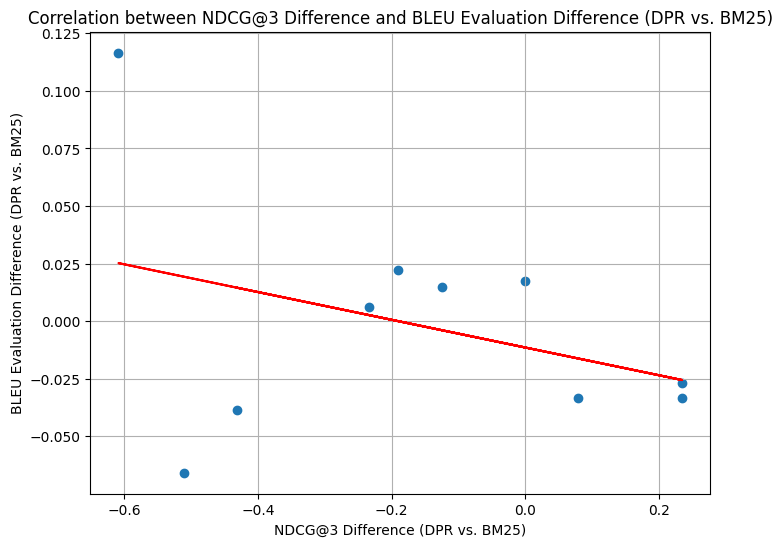

The Correlation Coefficient is:  -0.06018920327370925


In [73]:
# Calculate the difference in NDCG@3 and evaluation measure scores
ndcg_diff_1 = [x - y for x, y in zip(ndcg_3_bm25_per_query, ndcg_3_dpr_per_query)]
eval_measure_1_diff = [x - y for x, y in zip(bm25_rag_bleu, dpr_rag_bleu)]

# Create the correlation plot for measure 1
plt.figure(figsize=(8, 6))
plt.scatter(ndcg_diff_1, eval_measure_1_diff)
plt.xlabel("NDCG@3 Difference (DPR vs. BM25)")
plt.ylabel("BLEU Evaluation Difference (DPR vs. BM25)")
plt.title("Correlation between NDCG@3 Difference and BLEU Evaluation Difference (DPR vs. BM25)")
plt.grid(True)

# Add a coefficient line
m, b = np.polyfit(ndcg_diff_1, eval_measure_1_diff, 1)
plt.plot(ndcg_diff_1, m * np.array(ndcg_diff_1) + b, color='red')

plt.show()

print("The Correlation Coefficient is: ", m)

#### Correlation Plot between BM25 and DPR with ROGUE

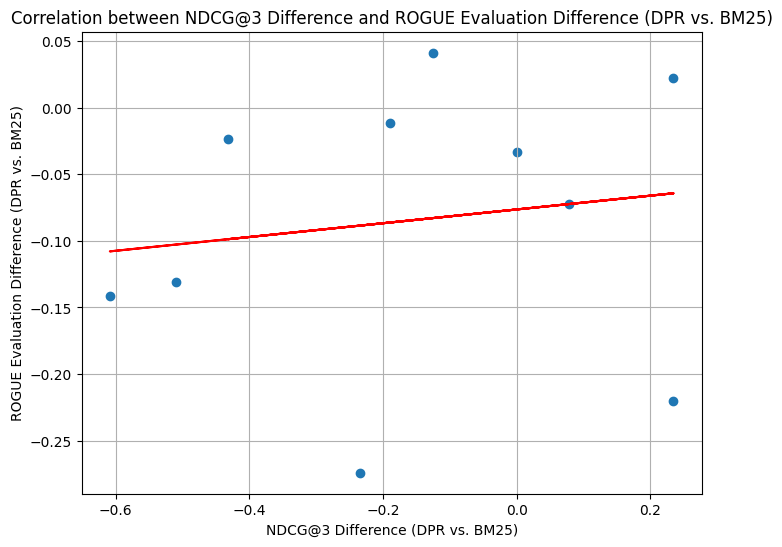

The Correlation Coefficient is:  0.05171751423956528


In [74]:
# Calculate the difference in NDCG@3 and evaluation measure scores
ndcg_diff_1 = [x - y for x, y in zip(ndcg_3_bm25_per_query, ndcg_3_dpr_per_query)]
eval_measure_1_diff = [x - y for x, y in zip(bm25_rag_rogue, dpr_rag_rogue)]

# Create the correlation plot for measure 1
plt.figure(figsize=(8, 6))
plt.scatter(ndcg_diff_1, eval_measure_1_diff)
plt.xlabel("NDCG@3 Difference (DPR vs. BM25)")
plt.ylabel("ROGUE Evaluation Difference (DPR vs. BM25)")
plt.title("Correlation between NDCG@3 Difference and ROGUE Evaluation Difference (DPR vs. BM25)")
plt.grid(True)

# Add a coefficient line
m, b = np.polyfit(ndcg_diff_1, eval_measure_1_diff, 1)
plt.plot(ndcg_diff_1, m * np.array(ndcg_diff_1) + b, color='red')

plt.show()

print("The Correlation Coefficient is: ", m)

#### Correlation Plot between BM25 and DPR with Embedding Similarity

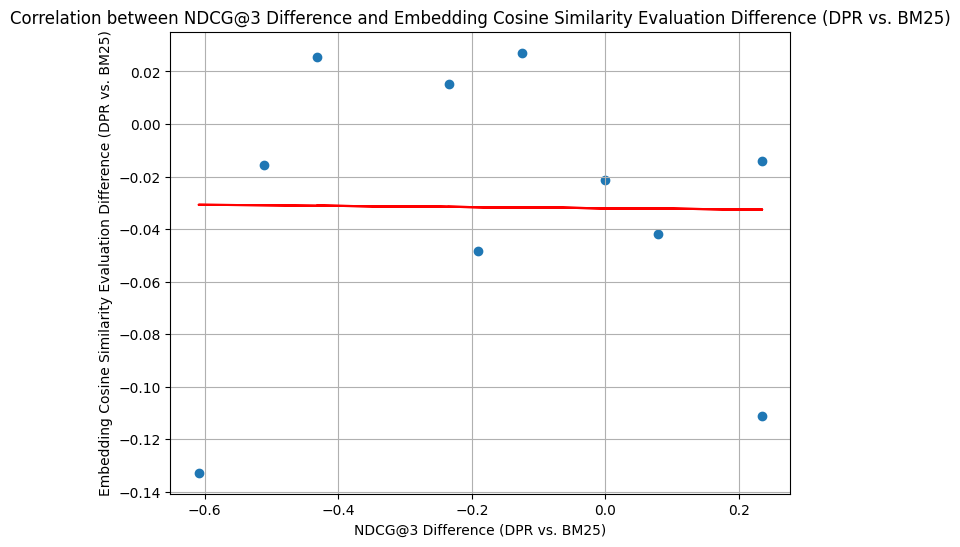

The Correlation Coefficient is:  -0.0021839952984497256


In [75]:
# Calculate the difference in NDCG@3 and evaluation measure scores
ndcg_diff_1 = [x - y for x, y in zip(ndcg_3_bm25_per_query, ndcg_3_dpr_per_query)]
eval_measure_1_diff = [x - y for x, y in zip(bm25_rag_embed_sim, dpr_rag_embed_sim)]

# Create the correlation plot for measure 1
plt.figure(figsize=(8, 6))
plt.scatter(ndcg_diff_1, eval_measure_1_diff)
plt.xlabel("NDCG@3 Difference (DPR vs. BM25)")
plt.ylabel("Embedding Cosine Similarity Evaluation Difference (DPR vs. BM25)")
plt.title("Correlation between NDCG@3 Difference and Embedding Cosine Similarity Evaluation Difference (DPR vs. BM25)")
plt.grid(True)

# Add a coefficient line
m, b = np.polyfit(ndcg_diff_1, eval_measure_1_diff, 1)
plt.plot(ndcg_diff_1, m * np.array(ndcg_diff_1) + b, color='red')

plt.show()

print("The Correlation Coefficient is: ", m)

#### Correlation Plot between BM25 and DPR with LLM Evaluation

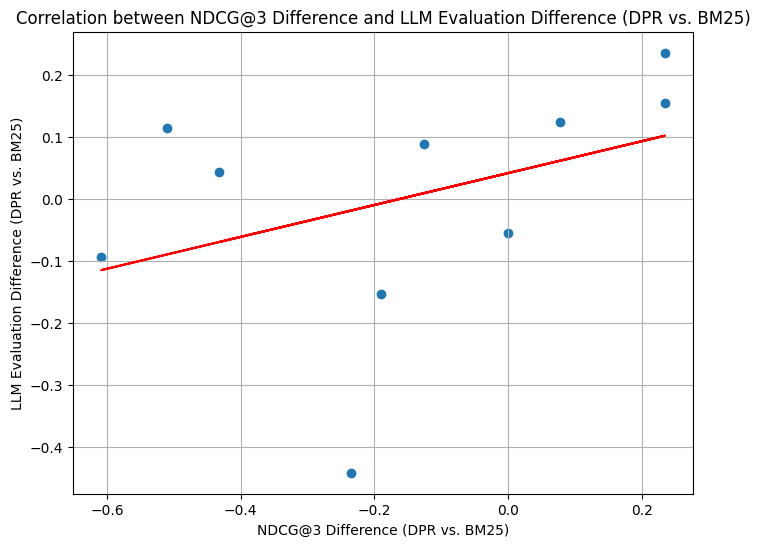

The Correlation Coefficient is:  0.2567329452511316


In [76]:
# Calculate the difference in NDCG@3 and evaluation measure scores
ndcg_diff_1 = [x - y for x, y in zip(ndcg_3_bm25_per_query, ndcg_3_dpr_per_query)]
eval_measure_1_diff = [x - y for x, y in zip(bm25_rag_llm_eval, dpr_rag_llm_eval)]

# Create the correlation plot for measure 1
plt.figure(figsize=(8, 6))
plt.scatter(ndcg_diff_1, eval_measure_1_diff)
plt.xlabel("NDCG@3 Difference (DPR vs. BM25)")
plt.ylabel("LLM Evaluation Difference (DPR vs. BM25)")
plt.title("Correlation between NDCG@3 Difference and LLM Evaluation Difference (DPR vs. BM25)")
plt.grid(True)

# Add a coefficient line
m, b = np.polyfit(ndcg_diff_1, eval_measure_1_diff, 1)
plt.plot(ndcg_diff_1, m * np.array(ndcg_diff_1) + b, color='red')

plt.show()

print("The Correlation Coefficient is: ", m)

### Discussion: *Retrieval Effectiveness and Generation Quality*

2. Perform the **correlation** plotting and answer the question: How does retrieval effectiveness impact the quality of the generated responses, and why?

Since DPR was the most effective IR technique from task 1, all correlation plots were created to compare RAG with DPR against RAG with BM25. The following discussion will also focus only on these comparisons.

Observing the first correlation plot of RAG with DPR vs RAG with BM25, we focus on the correlation between nDCG@3, which was the metric used for evaluating the standalone IR techniques, and the BLEU evaluation strategy used for evaluating RAG results. By performing the correlation plotting, we find that the correlation coefficient between nDCG@3 and BLEU for the two RAG strategies was -0.06018, indicating a negative correlation. This means that as the nDCG@3 metric for the IR method decreases, BLEU tends to increase. Thus, better retrieval effectiveness does not mean RAG responses when evaluated using BLEU will increase. The reason why we see this is likely because of how the BLEU evaluation strategy words. Since BLEU focuses on how closely a generated response will match a reference response, if the underlying retrieval method is improved, it may actually give the model more information that does not have the same terms as the reference and therefore cause BLEU to decrease. Additionally, since DPR will retrieve contextually relevant documents, it might find information that is more diverse and less similar to the specific phrasing used in reference responses. The BM25 RAG strategy, being more keyword-based, might result in responses that are more succinct or aligned with reference text, leading to better BLEU scores even if the overall relevance (nDCG@3) is lower.

Considering the second correlation plot of RAG with DPR vs BM25 as the retrieval method, we can now find a slight positive correlation between nDCG@3 and ROGUE, with a correlation coefficient of 0.05171. This means that as nDCG@3 improves, the ROGUE score difference also slightly improves, but the relationship is weak. This suggests that better retrieval effectiveness (higher nDCG@3) may lead to slight improvements in the ROGUE score, which is designed to measure recall-based alignment between the generated response and the reference. Since DPR may retrieve documents that have better coverage of relevant terms, this might explain why there is a weak positive correlation between improved retrieval (nDCG@3) and ROGUE scores, since better coverage of terms will give the LLM more information to work with and a higher likelihood of producing a response that covers most of the terms present in teh reference response.

Now for the third correlation plot between nDCG@3 and Embedding Cosine Similarity, we can observe an extremely weak negative correlation with a coefficient of -0.00218. Since the correlation is almost non-existent (very close to 0), it could indicate that better retrieval performance (higher nDCG@3) does not necessarily translate into embedding spaces that are closer or more aligned. In other words, the quality of the documents retrieved by DPR or BM25 may not have a direct or strong influence on how well the embedding representations of the responses match the reference. The reason why we can observe this trend may be because RAG is using a LLM to generate its responses, and since we give the LLM the original query to answer, its answer will always be semantically similar to the expected reference answer, even if the documents retrieved by the retrieval method and used as context for the LLM during RAG generation are incorrect or completely irrelevant.

Finally, for the final correlation plot between nDCG@3 and LLM evaluation, we can observe a moderate positive correlation with a coefficient of 0.25673, indicating an increase in nDCG@3 will lead to the LLM rating a response higher. This positive relationship could be explained by the fact that higher nDCG@3 reflects more relevant documents being retrieved at the top ranks. With better retrieval, the LLM has access to more useful information, potentially allowing it to generate responses that are more aligned with the query and reference responses. However, the correlation is not particularly strong at only 0.25673. This indicates that while retrieval quality can impact the LLM’s performance, other factors (such as how the LLM processes and utilizes the retrieved documents) also play a significant role in determining the quality of RAG generated responses.

In summary, considering all 4 correlation plots we have created, we can find that retrieval effectiveness can have an impact on the quality of generated responses. However, the way we measure the quality of generated responses also matters significantly. When using traditional evaluation methods for RAG responses, such as BLEU and ROGUE that only look for matching key words, different correlation patterns arise and so retrieval effectiveness will be important if you wish to maximise one of these metrics. Additionally, we find that when using LLMs to generate RAG responses, semantic context will likely not be affected by the retrieval effectiveness, which is likely due to the LLM in RAG understanding it needs to give a response that is somewhat related to the provided query.

Overall, however, retrieval effectiveness will impact the quality of RAG responses. This is something we can see when using a LLM to rate responses, where retrieval effectiveness will help to improve the overall quality of generated responses, since the LLM-as-a-judge method considers the response's relevance to the original query, and its accuracy when compared to the reference answer. The reason for this occurring is that a more effective retriever can provide better context and information during RAG, therefore allowing the RAG pipeline to generate answers that are more accurate and relevant to the initial query. With a poor performing retriever, the LLM would be fed incorrect information, which would lead to worse generated results.